# Import the libraries

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sn
import skimage.io
import os 
import tqdm
import csv
import glob
import tensorflow 
import pickle

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image

from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the data

In [ ]:
!unzip /content/gdrive/MyDrive/Conference\ on\ Soft\ Computing\ and\ Pattern\ Recognition\ \(SoCPaR\ 2022\)/Source/Chest\ CT-Scan\ images/data.zip -d /content/data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    rotation_range=5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    #zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = 'data/Data/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   batch_size = 64)

Found 613 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'data/Data/valid',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 72 images belonging to 4 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = 'data/Data/test',
                                                target_size = (224,224),
                                                class_mode = 'categorical',
                                                batch_size = 64)

Found 315 images belonging to 4 classes.


# Methods

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

# Models

In [ ]:
def get_base_model(model_name, tranfer):
  model_name = model_name.lower()
  if tranfer:
    if model_name == 'vgg16':
      base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
    elif model_name == 'mobilenetv3large':
      base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
    elif model_name == 'mobilenetv3small':
      base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
    elif model_name == 'efficientnetv2l':
      base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
    elif model_name == 'inceptionresnetv2':
      base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
    elif model_name == 'resnet152V2':
      base_model = tf.keras.applications.resnet_v2.ResNet152V2(input_shape=(224, 224, 3), include_top = False, weights = 'imagenet')
  else:
    print(tranfer)
    if model_name == 'vgg16':
      base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top = False, weights = None)
    elif model_name == 'mobilenetv3large':
      base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), include_top = False, weights = None)
    elif model_name == 'mobilenetv3small':
      base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top = False, weights = None)
    elif model_name == 'efficientnetv2l':
      base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(input_shape=(224, 224, 3), include_top = False, weights = None)
    elif model_name == 'inceptionresnetv2':
      base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224, 224, 3), include_top = False, weights = None)
    elif model_name == 'resnet152v2':
      base_model = tf.keras.applications.resnet_v2.ResNet152V2(input_shape=(224, 224, 3), include_top = False, weights = None)

  return base_model

In [ ]:
def huge(model_name, tranfer = True):
  base_model = get_base_model(model_name, tranfer)
  for layer in base_model.layers[:-8]:
    layer.trainable=False

  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(4,activation='softmax'))

  return model

In [ ]:
def large(model_name, tranfer = True):
  base_model = get_base_model(model_name, tranfer)
  for layer in base_model.layers[:-8]:
    layer.trainable=False

  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(4,activation='softmax'))

  return model

In [ ]:
def medium(model_name, tranfer = True):
  base_model = get_base_model(model_name, tranfer)
  for layer in base_model.layers[:-8]:
    layer.trainable=False

  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(32,kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dense(4,activation='softmax'))

  return model

In [ ]:
def small(model_name, tranfer = True):
  base_model = get_base_model(model_name, tranfer)
  for layer in base_model.layers[:-8]:
    layer.trainable=False

  model=Sequential()
  model.add(base_model)
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(BatchNormalization())
  
  model.add(Activation('relu'))
  model.add(Dense(4,activation='softmax'))

  return model

In [ ]:
def tiny(model_name, tranfer = True):
  base_model = get_base_model(model_name, tranfer)
  for layer in base_model.layers[:-8]:
    layer.trainable=False

  model=Sequential()
  model.add(base_model)
  model.add(Flatten())
  # model.add(BatchNormalization())
  model.add(Dense(4,activation='softmax'))
  return model

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, factor = 0.50, min_lr = 1e-7)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=5)

# Transfer Learning

## VGG16

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('vgg16')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 31s 2s/step - loss: 1.5935 - accuracy: 0.7178 - precision: 0.2910 - recall: 0.0897 - auc: 0.5304 - f1_score: 0.1379 - val_loss: 273.1788 - val_accuracy: 0.6458 - val_precision: 0.2917 - val_recall: 0.2917 - val_auc: 0.5278 - val_f1_score: 0.2734 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.4001 - accuracy: 0.7423 - precision: 0.4410 - recall: 0.1158 - auc: 0.6087 - f1_score: 0.1785 - val_loss: 97.0402 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.3880 - accuracy: 0.7476 - precision: 0.4773 - recall: 0.1028 - auc: 0.6177 - f1_score: 0.1692 - val_loss: 253.3543 - val_accuracy: 0.5972 - val_precision: 0.1944 - val_recall: 0.1944 - val_auc: 0.4601 - val_f1_score: 0.2187 - lr: 0.0010
Epo

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  10.8279390335083
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4528982937335968
f1_score:  0.17192791402339935
****************************************************************************************************
loss:  25.38799285888672
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4476190209388733
f1_score:  0.17113342881202698
****************************************************************************************************
loss:  2.0426113605499268
accuracy:  0.6722221970558167
precision:  0.26442307233810425
recall:  0.1746031790971756
auc:  0.5837390422821045
f1_score:  0.20957300066947937
****************************************************************************************************
loss:  49.34751892089844
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4476190209388733
f1_score:  0.1716630905866623
***********

### Large

In [ ]:
results = []
for i in range(10):
  model = large('vgg16')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 31s 2s/step - loss: 1.5479 - accuracy: 0.7251 - precision: 0.3106 - recall: 0.0816 - auc: 0.5301 - f1_score: 0.1338 - val_loss: 68.8192 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4499 - val_f1_score: 0.1016 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.5201 - accuracy: 0.7194 - precision: 0.2905 - recall: 0.0848 - auc: 0.5463 - f1_score: 0.1262 - val_loss: 62.1656 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4423 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.3632 - accuracy: 0.7439 - precision: 0.4497 - recall: 0.1093 - auc: 0.6212 - f1_score: 0.1802 - val_loss: 108.4932 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1016 - lr: 0.0010
Epoc

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  12.371142387390137
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4487830698490143
f1_score:  0.17113342881202698
****************************************************************************************************
loss:  21.248334884643555
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4476190209388733
f1_score:  0.17192791402339935
****************************************************************************************************
loss:  15.73779010772705
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4490400552749634
f1_score:  0.17113342881202698
****************************************************************************************************
loss:  4.039601802825928
accuracy:  0.6253968477249146
precision:  0.21863798797130585
recall:  0.19365079700946808
auc:  0.5075989365577698
f1_score:  0.20583149790763855
*******

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('vgg16')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 32s 2s/step - loss: 1.4339 - accuracy: 0.7369 - precision: 0.4316 - recall: 0.1648 - auc: 0.6052 - f1_score: 0.2433 - val_loss: 324.7404 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.2351 - accuracy: 0.7753 - precision: 0.5928 - recall: 0.3230 - auc: 0.7311 - f1_score: 0.4126 - val_loss: 269.9575 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1016 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.1972 - accuracy: 0.7618 - precision: 0.5430 - recall: 0.2985 - auc: 0.7491 - f1_score: 0.3802 - val_loss: 117.8738 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Ep

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.2180802822113037
accuracy:  0.708730161190033
precision:  0.4127516746520996
recall:  0.39047619700431824
auc:  0.7040531039237976
f1_score:  0.4012647271156311
****************************************************************************************************
loss:  7.8374409675598145
accuracy:  0.5968254208564758
precision:  0.17940199375152588
recall:  0.17142857611179352
auc:  0.4619182348251343
f1_score:  0.17667236924171448
****************************************************************************************************
loss:  1.4700076580047607
accuracy:  0.7873015999794006
precision:  0.5951417088508606
recall:  0.46666666865348816
auc:  0.7904542684555054
f1_score:  0.5216124057769775
****************************************************************************************************
loss:  1.4170054197311401
accuracy:  0.6499999761581421
precision:  0.29411765933036804
recall:  0.2857142984867096
auc:  0.6740891933441162
f1_score:  0.2888970375061035
************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('vgg16')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 1.4331 - accuracy: 0.7557 - precision: 0.5436 - recall: 0.1412 - auc: 0.6388 - f1_score: 0.0921 - val_loss: 22.2486 - val_accuracy: 0.6875 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.5923 - val_f1_score: 0.4297 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.4566 - accuracy: 0.7443 - precision: 0.3542 - recall: 0.0277 - auc: 0.5322 - f1_score: 0.0512 - val_loss: 112.0713 - val_accuracy: 0.6667 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5691 - val_f1_score: 0.2969 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.4811 - accuracy: 0.7349 - precision: 0.3806 - recall: 0.0962 - auc: 0.5363 - f1_score: 0.1417 - val_loss: 119.6290 - val_accuracy: 0.5764 - val_precision: 0.1528 - val_recall: 0.1528 - val_auc: 0.4325 - val_f1_score: 0.1406 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/step - lo

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  654.1112670898438
accuracy:  0.6539682745933533
precision:  0.30793651938438416
recall:  0.30793651938438416
auc:  0.54139244556427
f1_score:  0.3084215521812439
****************************************************************************************************
loss:  26.891443252563477
accuracy:  0.6896825432777405
precision:  0.3642857074737549
recall:  0.32380953431129456
auc:  0.5595028400421143
f1_score:  0.3427635133266449
****************************************************************************************************
loss:  1.5404772758483887
accuracy:  0.7174603343009949
precision:  0.2469135820865631
recall:  0.0634920671582222
auc:  0.6779877543449402
f1_score:  0.10116712749004364
****************************************************************************************************
loss:  3.456317901611328
accuracy:  0.5809524059295654
precision:  0.16190476715564728
recall:  0.16190476715564728
auc:  0.5263374447822571
f1_score:  0.1617584228515625
***************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('vgg16')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 13s 1s/step - loss: 1.2307 - accuracy: 0.7244 - precision: 0.4174 - recall: 0.2586 - auc: 0.6492 - f1_score: 0.3680 - val_loss: 316.2668 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2109 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.0494 - accuracy: 0.7924 - precision: 0.6250 - recall: 0.4241 - auc: 0.8062 - f1_score: 0.5060 - val_loss: 237.5468 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.0253 - accuracy: 0.7867 - precision: 0.6077 - recall: 0.4144 - auc: 0.8136 - f1_score: 0.4946 - val_loss: 132.3286 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/step - l

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  26.66509246826172
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.44624507427215576
f1_score:  0.17113342881202698
****************************************************************************************************
loss:  3.4879589080810547
accuracy:  0.670634925365448
precision:  0.33766233921051025
recall:  0.3301587402820587
auc:  0.626943826675415
f1_score:  0.3335714340209961
****************************************************************************************************
loss:  0.9142659306526184
accuracy:  0.7960317730903625
precision:  0.6066176295280457
recall:  0.523809552192688
auc:  0.8555135726928711
f1_score:  0.5610188245773315
****************************************************************************************************
loss:  185.09759521484375
accuracy:  0.6666666865348816
precision:  0.3333333432674408
recall:  0.3333333432674408
auc:  0.5560829639434814
f1_score:  0.3334215581417084
****************

## MobileNetV3Large

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('mobilenetv3large')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.5312 - accuracy: 0.6988 - precision: 0.2487 - recall: 0.1013 - auc: 0.5338 - f1_score: 0.0479 - val_loss: 1.3578 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6097 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 1.3778 - accuracy: 0.7325 - precision: 0.2784 - recall: 0.0440 - auc: 0.6091 - f1_score: 0.0741 - val_loss: 1.3079 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6739 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 909ms/step - loss: 1.2989 - accuracy: 0.7439 - precision: 0.4299 - recall: 0.0750 - auc: 0.6632 - f1_score: 0.1260 - val_loss: 1.2832 - val_accuracy: 0.7569 - val_precision: 1.0000 - val_recall: 0.0278 - val_auc: 0.6858 - val_f1_score: 0.

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3202611207962036
accuracy:  0.7484126687049866
precision:  0.4000000059604645
recall:  0.012698412872850895
auc:  0.6484320759773254
f1_score:  0.02379545569419861
****************************************************************************************************
loss:  1.1569894552230835
accuracy:  0.7642857432365417
precision:  1.0
recall:  0.05714285746216774
auc:  0.7392273545265198
f1_score:  0.10611243546009064
****************************************************************************************************
loss:  1.1165739297866821
accuracy:  0.7730158567428589
precision:  1.0
recall:  0.09206349402666092
auc:  0.7851448059082031
f1_score:  0.16206201910972595
****************************************************************************************************
loss:  1.114235758781433
accuracy:  0.7777777910232544
precision:  0.9729729890823364
recall:  0.11428571492433548
auc:  0.776418924331665
f1_score:  0.2037384808063507
*****************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('mobilenetv3large')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 18s 1s/step - loss: 1.3439 - accuracy: 0.7484 - precision: 0.4942 - recall: 0.2748 - auc: 0.6675 - f1_score: 0.2529 - val_loss: 1.5998 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5012 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 912ms/step - loss: 1.1701 - accuracy: 0.7761 - precision: 0.6905 - recall: 0.1892 - auc: 0.7503 - f1_score: 0.2947 - val_loss: 1.3703 - val_accuracy: 0.7674 - val_precision: 1.0000 - val_recall: 0.0694 - val_auc: 0.5810 - val_f1_score: 0.0725 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 900ms/step - loss: 1.1103 - accuracy: 0.7859 - precision: 0.7391 - recall: 0.2219 - auc: 0.7887 - f1_score: 0.3420 - val_loss: 1.2946 - val_accuracy: 0.7812 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.5971 - val_f1_score: 0.2222 - lr:

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.2868627309799194
accuracy:  0.7714285850524902
precision:  1.0
recall:  0.08571428805589676
auc:  0.665818452835083
f1_score:  0.15644651651382446
****************************************************************************************************
loss:  1.2515153884887695
accuracy:  0.7896825671195984
precision:  0.9807692170143127
recall:  0.16190476715564728
auc:  0.6072074770927429
f1_score:  0.27382588386535645
****************************************************************************************************
loss:  1.3690730333328247
accuracy:  0.7420634627342224
precision:  0.3076923191547394
recall:  0.02539682574570179
auc:  0.634109377861023
f1_score:  0.046846091747283936
****************************************************************************************************
loss:  1.3155922889709473
accuracy:  0.7531746029853821
precision:  0.6000000238418579
recall:  0.03809523954987526
auc:  0.6693743467330933
f1_score:  0.0697815790772438
**************************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('mobilenetv3large')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.1247 - accuracy: 0.7732 - precision: 0.6748 - recall: 0.1789 - auc: 0.7508 - f1_score: 0.3568 - val_loss: 1.3894 - val_accuracy: 0.6771 - val_precision: 0.3333 - val_recall: 0.2917 - val_auc: 0.6263 - val_f1_score: 0.4262 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 902ms/step - loss: 1.0178 - accuracy: 0.7961 - precision: 0.6782 - recall: 0.3507 - auc: 0.8246 - f1_score: 0.4595 - val_loss: 1.2404 - val_accuracy: 0.7535 - val_precision: 0.5263 - val_recall: 0.1389 - val_auc: 0.7033 - val_f1_score: 0.1250 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 972ms/step - loss: 0.9693 - accuracy: 0.7957 - precision: 0.6667 - recall: 0.3654 - auc: 0.8352 - f1_score: 0.4706 - val_loss: 1.2379 - val_accuracy: 0.7535 - val_precision: 0.5238 - val_recall: 0.1528 - val_auc: 0.7016 - val_f1_score: 0.2302 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 9s 902ms/step - 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.274509310722351
accuracy:  0.7396825551986694
precision:  0.3333333432674408
recall:  0.04126984253525734
auc:  0.6385000348091125
f1_score:  0.07557205855846405
****************************************************************************************************
loss:  1.276632308959961
accuracy:  0.7563492059707642
precision:  0.699999988079071
recall:  0.04444444552063942
auc:  0.63921058177948
f1_score:  0.08348386734724045
****************************************************************************************************
loss:  1.5472062826156616
accuracy:  0.7357142567634583
precision:  0.23529411852359772
recall:  0.02539682574570179
auc:  0.6882808804512024
f1_score:  0.045983828604221344
****************************************************************************************************
loss:  1.4532930850982666
accuracy:  0.7428571581840515
precision:  0.23529411852359772
recall:  0.012698412872850895
auc:  0.6302931308746338
f1_score:  0.02389124035835266
**********

### Small

In [ ]:
results = []
for i in range(10):
  model = small('mobilenetv3large')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

12683000/12683000 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.3933 - accuracy: 0.6996 - precision: 0.3714 - recall: 0.2909 - auc: 0.6338 - f1_score: 0.3899 - val_loss: 2.4083 - val_accuracy: 0.6528 - val_precision: 0.3000 - val_recall: 0.2917 - val_auc: 0.5383 - val_f1_score: 0.2212 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 905ms/step - loss: 1.1333 - accuracy: 0.7667 - precision: 0.5519 - recall: 0.3556 - auc: 0.7961 - f1_score: 0.4346 - val_loss: 1.6971 - val_accuracy: 0.6701 - val_precision: 0.3284 - val_recall: 0.3056 - val_auc: 0.5956 - val_f1_score: 0.2332 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 907ms/step - loss: 1.1520 - accuracy: 0.7773 - precision: 0.5661 - recall: 0.4682 - auc: 0.8065 - f1_score: 0.5074 - val_loss: 2.1279 - val_accuracy: 0.6736 - val_precision: 0.3382 - val_recall: 0.3194 - val_auc: 0.6219 - val_f1_score: 0.4032 - lr: 0.0010
Epoc

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.299722194671631
accuracy:  0.6261904835700989
precision:  0.23469388484954834
recall:  0.21904762089252472
auc:  0.5805140137672424
f1_score:  0.22636957466602325
****************************************************************************************************
loss:  4.048535346984863
accuracy:  0.6428571343421936
precision:  0.2857142984867096
recall:  0.2857142984867096
auc:  0.48739057779312134
f1_score:  0.28601688146591187
****************************************************************************************************
loss:  2.064690589904785
accuracy:  0.7396825551986694
precision:  0.4793650805950165
recall:  0.4793650805950165
auc:  0.7373108267784119
f1_score:  0.4811440110206604
****************************************************************************************************
loss:  1.7844644784927368
accuracy:  0.6952381134033203
precision:  0.35564854741096497
recall:  0.2698412835597992
auc:  0.6419417262077332
f1_score:  0.30803292989730835
*************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('mobilenetv3large')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 1.5094 - accuracy: 0.7702 - precision: 0.5731 - recall: 0.3168 - auc: 0.7625 - f1_score: 0.4815 - val_loss: 1.4852 - val_accuracy: 0.6493 - val_precision: 0.2769 - val_recall: 0.2500 - val_auc: 0.5950 - val_f1_score: 0.3115 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 945ms/step - loss: 1.3388 - accuracy: 0.7610 - precision: 0.5245 - recall: 0.4715 - auc: 0.7961 - f1_score: 0.4918 - val_loss: 1.5022 - val_accuracy: 0.6944 - val_precision: 0.3621 - val_recall: 0.2917 - val_auc: 0.6434 - val_f1_score: 0.3565 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 943ms/step - loss: 1.3229 - accuracy: 0.7818 - precision: 0.5756 - recall: 0.4845 - auc: 0.8134 - f1_score: 0.5266 - val_loss: 1.4594 - val_accuracy: 0.7326 - val_precision: 0.4444 - val_recall: 0.2778 - val_auc: 0.6335 - val_f1_score: 0.4235 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 9s 896ms/step - l

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.648834705352783
accuracy:  0.6388888955116272
precision:  0.2569444477558136
recall:  0.23492063581943512
auc:  0.563606321811676
f1_score:  0.24534013867378235
****************************************************************************************************
loss:  2.131272554397583
accuracy:  0.6428571343421936
precision:  0.24137930572032928
recall:  0.20000000298023224
auc:  0.5369328856468201
f1_score:  0.22005996108055115
****************************************************************************************************
loss:  3.5292882919311523
accuracy:  0.5888888835906982
precision:  0.17152103781700134
recall:  0.16825397312641144
auc:  0.5036903619766235
f1_score:  0.16958191990852356
****************************************************************************************************
loss:  1.114818811416626
accuracy:  0.7547619342803955
precision:  0.5153061151504517
recall:  0.3206349313259125
auc:  0.7667809128761292
f1_score:  0.39378032088279724
************

## MobileNetV3Small

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('mobilenetv3small')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 24s 980ms/step - loss: 1.5086 - accuracy: 0.7280 - precision: 0.3689 - recall: 0.1240 - auc: 0.5751 - f1_score: 0.1824 - val_loss: 1.3482 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6238 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 8s 852ms/step - loss: 1.4061 - accuracy: 0.7406 - precision: 0.4372 - recall: 0.1305 - auc: 0.6095 - f1_score: 0.1927 - val_loss: 1.3300 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6173 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 8s 834ms/step - loss: 1.3373 - accuracy: 0.7443 - precision: 0.4573 - recall: 0.1223 - auc: 0.6420 - f1_score: 0.1915 - val_loss: 1.3537 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5598 - val_f

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3806856870651245
accuracy:  0.7634920477867126
precision:  1.0
recall:  0.05396825447678566
auc:  0.5615519881248474
f1_score:  0.10277561843395233
****************************************************************************************************
loss:  1.3792855739593506
accuracy:  0.7928571701049805
precision:  1.0
recall:  0.17142857611179352
auc:  0.5838078260421753
f1_score:  0.28746381402015686
****************************************************************************************************
loss:  1.2195467948913574
accuracy:  0.773809552192688
precision:  1.0
recall:  0.095238097012043
auc:  0.7322230339050293
f1_score:  0.16997301578521729
****************************************************************************************************
loss:  1.2167543172836304
accuracy:  0.7563492059707642
precision:  1.0
recall:  0.02539682574570179
auc:  0.7251011729240417
f1_score:  0.04900601506233215
************************************************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('mobilenetv3small')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 24s 1s/step - loss: 1.2981 - accuracy: 0.7577 - precision: 0.5531 - recall: 0.1615 - auc: 0.6563 - f1_score: 0.2436 - val_loss: 1.4981 - val_accuracy: 0.7535 - val_precision: 1.0000 - val_recall: 0.0139 - val_auc: 0.5016 - val_f1_score: 0.0154 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 863ms/step - loss: 1.1525 - accuracy: 0.7761 - precision: 0.6667 - recall: 0.2088 - auc: 0.7487 - f1_score: 0.3145 - val_loss: 1.3768 - val_accuracy: 0.7708 - val_precision: 1.0000 - val_recall: 0.0833 - val_auc: 0.5746 - val_f1_score: 0.0857 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 871ms/step - loss: 1.1243 - accuracy: 0.7798 - precision: 0.6853 - recall: 0.2202 - auc: 0.7589 - f1_score: 0.3316 - val_loss: 1.3707 - val_accuracy: 0.7778 - val_precision: 1.0000 - val_recall: 0.1111 - val_auc: 0.5131 - val_f1_score: 0.2857 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.218973994255066
accuracy:  0.7801587581634521
precision:  1.0
recall:  0.12063492089509964
auc:  0.7451851963996887
f1_score:  0.21380352973937988
****************************************************************************************************
loss:  1.6188122034072876
accuracy:  0.7825396656990051
precision:  1.0
recall:  0.13015873730182648
auc:  0.4309464991092682
f1_score:  0.2293941080570221
****************************************************************************************************
loss:  1.3125847578048706
accuracy:  0.7563492059707642
precision:  1.0
recall:  0.02539682574570179
auc:  0.5915277004241943
f1_score:  0.04918414354324341
****************************************************************************************************
loss:  1.2544833421707153
accuracy:  0.7563492059707642
precision:  1.0
recall:  0.02539682574570179
auc:  0.7267305254936218
f1_score:  0.048471130430698395
**********************************************************************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('mobilenetv3small')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

4334752/4334752 [==============================] - 0s 0us/step
Epoch 1/20
10/10 [==============================] - 24s 1s/step - loss: 1.1939 - accuracy: 0.7606 - precision: 0.5417 - recall: 0.2757 - auc: 0.7347 - f1_score: 0.3644 - val_loss: 1.3926 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6544 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 868ms/step - loss: 1.0561 - accuracy: 0.7851 - precision: 0.6493 - recall: 0.3051 - auc: 0.7914 - f1_score: 0.4172 - val_loss: 1.3631 - val_accuracy: 0.7535 - val_precision: 1.0000 - val_recall: 0.0139 - val_auc: 0.6300 - val_f1_score: 0.0154 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 861ms/step - loss: 0.9955 - accuracy: 0.7961 - precision: 0.6928 - recall: 0.3312 - auc: 0.8211 - f1_score: 0.4486 - val_loss: 1.3450 - val_accuracy: 0.7604 - val_precision: 1.0000 - val_recall: 0.0417 - val_auc: 0.6269 - val_f1_score: 0.0448 - lr: 0

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.5203497409820557
accuracy:  0.7698412537574768
precision:  1.0
recall:  0.0793650820851326
auc:  0.46857815980911255
f1_score:  0.14680215716362
****************************************************************************************************
loss:  1.5169544219970703
accuracy:  0.7753968238830566
precision:  1.0
recall:  0.10158730298280716
auc:  0.5840228796005249
f1_score:  0.1842184215784073
****************************************************************************************************
loss:  1.5944116115570068
accuracy:  0.6119047403335571
precision:  0.19148936867713928
recall:  0.17142857611179352
auc:  0.5430184006690979
f1_score:  0.17932066321372986
****************************************************************************************************
loss:  1.5924155712127686
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5712858438491821
f1_score:  0.0
****************************************************************************************************
lo

### Small

In [ ]:
results = []
for i in range(10):
  model = small('mobilenetv3small')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 2.5892 - accuracy: 0.7029 - precision: 0.3281 - recall: 0.1800 - auc: 0.6002 - f1_score: 0.2737 - val_loss: 1.5732 - val_accuracy: 0.6840 - val_precision: 0.3443 - val_recall: 0.2917 - val_auc: 0.5744 - val_f1_score: 0.2874 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 851ms/step - loss: 1.5144 - accuracy: 0.7443 - precision: 0.4852 - recall: 0.3752 - auc: 0.7036 - f1_score: 0.4282 - val_loss: 1.4900 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5712 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 855ms/step - loss: 1.2434 - accuracy: 0.7577 - precision: 0.5243 - recall: 0.3344 - auc: 0.7356 - f1_score: 0.4090 - val_loss: 1.3789 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6514 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===========================

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.6259313821792603
accuracy:  0.5873016119003296
precision:  0.16612377762794495
recall:  0.16190476715564728
auc:  0.622022271156311
f1_score:  0.16375577449798584
****************************************************************************************************
loss:  1.4679515361785889
accuracy:  0.6309523582458496
precision:  0.2023809552192688
recall:  0.16190476715564728
auc:  0.5926329493522644
f1_score:  0.1792772263288498
****************************************************************************************************
loss:  1.423852562904358
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6520584225654602
f1_score:  0.0
****************************************************************************************************
loss:  1.7147009372711182
accuracy:  0.5809524059295654
precision:  0.16190476715564728
recall:  0.16190476715564728
auc:  0.5139766335487366
f1_score:  0.16122876107692719
***********************************************************************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('mobilenetv3small')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.4760 - accuracy: 0.7020 - precision: 0.3868 - recall: 0.3276 - auc: 0.6828 - f1_score: 0.4418 - val_loss: 1.3265 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6191 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 855ms/step - loss: 1.3077 - accuracy: 0.7667 - precision: 0.5401 - recall: 0.4502 - auc: 0.7953 - f1_score: 0.4987 - val_loss: 1.3299 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6415 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 856ms/step - loss: 1.1573 - accuracy: 0.7949 - precision: 0.6165 - recall: 0.4747 - auc: 0.8162 - f1_score: 0.5375 - val_loss: 1.3710 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5849 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.441197156906128
accuracy:  0.7857142686843872
precision:  1.0
recall:  0.1428571492433548
auc:  0.5514286160469055
f1_score:  0.24902665615081787
****************************************************************************************************
loss:  2.3460428714752197
accuracy:  0.6904761791229248
precision:  0.380952388048172
recall:  0.380952388048172
auc:  0.6193079352378845
f1_score:  0.37976688146591187
****************************************************************************************************
loss:  2.1861650943756104
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.5358461141586304
f1_score:  0.17192791402339935
****************************************************************************************************
loss:  1.7248196601867676
accuracy:  0.6904761791229248
precision:  0.380952388048172
recall:  0.380952388048172
auc:  0.5933618545532227
f1_score:  0.38109105825424194
*******************************

## EfficientNetV2L

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('efficientnetv2l')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

473176280/473176280 [==============================] - 2s 0us/step
Epoch 1/20
10/10 [==============================] - 53s 2s/step - loss: 1.5452 - accuracy: 0.6797 - precision: 0.1929 - recall: 0.0884 - auc: 0.5357 - f1_score: 0.0756 - val_loss: 4.1190 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.5493 - val_f1_score: 0.3984 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 1.4885 - accuracy: 0.7251 - precision: 0.2479 - recall: 0.0489 - auc: 0.5471 - f1_score: 0.0840 - val_loss: 2.8420 - val_accuracy: 0.6562 - val_precision: 0.2632 - val_recall: 0.2083 - val_auc: 0.5421 - val_f1_score: 0.1976 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 1.4587 - accuracy: 0.7268 - precision: 0.1935 - recall: 0.0294 - auc: 0.5477 - f1_score: 0.0527 - val_loss: 1.8082 - val_accuracy: 0.6910 - val_precision: 0.3111 - val_recall: 0.1944 - val_auc: 0.5565 - val_f1_score: 0.2215 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.5439797639846802
accuracy:  0.6896825432777405
precision:  0.29120880365371704
recall:  0.16825397312641144
auc:  0.5517527461051941
f1_score:  0.21297886967658997
****************************************************************************************************
loss:  1.58523690700531
accuracy:  0.682539701461792
precision:  0.2774869203567505
recall:  0.16825397312641144
auc:  0.5693877339363098
f1_score:  0.21138262748718262
****************************************************************************************************
loss:  1.6619371175765991
accuracy:  0.6611111164093018
precision:  0.23831775784492493
recall:  0.16190476715564728
auc:  0.5668749809265137
f1_score:  0.19308634102344513
****************************************************************************************************
loss:  1.5016626119613647
accuracy:  0.6936507821083069
precision:  0.28994083404541016
recall:  0.15555556118488312
auc:  0.5693491697311401
f1_score:  0.20097053050994873
*********

### Large

In [ ]:
results = []
for i in range(10):
  model = large('efficientnetv2l')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

473176280/473176280 [==============================] - 8s 0us/step
Epoch 1/20
10/10 [==============================] - 53s 3s/step - loss: 1.6268 - accuracy: 0.7422 - precision: 0.4241 - recall: 0.0873 - auc: 0.5513 - f1_score: 0.1127 - val_loss: 3.3913 - val_accuracy: 0.6458 - val_precision: 0.2917 - val_recall: 0.2917 - val_auc: 0.5785 - val_f1_score: 0.2187 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 2s/step - loss: 1.4799 - accuracy: 0.7308 - precision: 0.3401 - recall: 0.0816 - auc: 0.5978 - f1_score: 0.1278 - val_loss: 2.0276 - val_accuracy: 0.6493 - val_precision: 0.2958 - val_recall: 0.2917 - val_auc: 0.6223 - val_f1_score: 0.2746 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 1.4076 - accuracy: 0.7459 - precision: 0.4615 - recall: 0.0979 - auc: 0.6338 - f1_score: 0.1592 - val_loss: 1.4819 - val_accuracy: 0.7014 - val_precision: 0.3939 - val_recall: 0.3611 - val_auc: 0.6511 - val_f1_score: 0.3998 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.7382506132125854
accuracy:  0.6698412895202637
precision:  0.256038635969162
recall:  0.16825397312641144
auc:  0.5706911683082581
f1_score:  0.2027205228805542
****************************************************************************************************
loss:  1.3153870105743408
accuracy:  0.7555555701255798
precision:  0.5321100950241089
recall:  0.18412698805332184
auc:  0.6353221535682678
f1_score:  0.272650808095932
****************************************************************************************************
loss:  2.0285980701446533
accuracy:  0.6150793433189392
precision:  0.1964285671710968
recall:  0.1746031790971756
auc:  0.5760862827301025
f1_score:  0.1836530566215515
****************************************************************************************************
loss:  1.888801097869873
accuracy:  0.64682537317276
precision:  0.22689075767993927
recall:  0.17142857611179352
auc:  0.521409273147583
f1_score:  0.19525189697742462
******************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('efficientnetv2l')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

473176280/473176280 [==============================] - 6s 0us/step
Epoch 1/20
10/10 [==============================] - 53s 2s/step - loss: 1.3653 - accuracy: 0.7470 - precision: 0.4762 - recall: 0.1185 - auc: 0.6518 - f1_score: 0.2607 - val_loss: 4.3304 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.5333 - val_f1_score: 0.3984 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 1.2136 - accuracy: 0.7577 - precision: 0.5324 - recall: 0.2545 - auc: 0.7305 - f1_score: 0.3424 - val_loss: 3.2316 - val_accuracy: 0.6667 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.6159 - val_f1_score: 0.2969 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 16s 2s/step - loss: 1.1379 - accuracy: 0.7688 - precision: 0.5898 - recall: 0.2463 - auc: 0.7546 - f1_score: 0.3461 - val_loss: 1.4717 - val_accuracy: 0.7396 - val_precision: 0.4789 - val_recall: 0.4722 - val_auc: 0.7419 - val_f1_score: 0.4316 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.5445823669433594
accuracy:  0.6912698149681091
precision:  0.3149999976158142
recall:  0.20000000298023224
auc:  0.6169984340667725
f1_score:  0.24338765442371368
****************************************************************************************************
loss:  1.2520345449447632
accuracy:  0.7317460179328918
precision:  0.42675158381462097
recall:  0.21269841492176056
auc:  0.7086101174354553
f1_score:  0.2838767468929291
****************************************************************************************************
loss:  1.6030548810958862
accuracy:  0.6793650984764099
precision:  0.2870813310146332
recall:  0.190476194024086
auc:  0.6216360330581665
f1_score:  0.22852495312690735
****************************************************************************************************
loss:  1.4192516803741455
accuracy:  0.7023809552192688
precision:  0.34210526943206787
recall:  0.2063492089509964
auc:  0.6545325517654419
f1_score:  0.2573206126689911
************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('efficientnetv2l')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 46s 2s/step - loss: 11.4064 - accuracy: 0.6797 - precision: 0.3253 - recall: 0.2619 - auc: 0.5743 - f1_score: 0.2673 - val_loss: 3.4808 - val_accuracy: 0.6597 - val_precision: 0.2903 - val_recall: 0.2500 - val_auc: 0.5718 - val_f1_score: 0.2095 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 4.5667 - accuracy: 0.7051 - precision: 0.4035 - recall: 0.3752 - auc: 0.6458 - f1_score: 0.3890 - val_loss: 1.1877 - val_accuracy: 0.7396 - val_precision: 0.4651 - val_recall: 0.2778 - val_auc: 0.7054 - val_f1_score: 0.3211 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 2.6780 - accuracy: 0.7019 - precision: 0.3931 - recall: 0.3540 - auc: 0.6437 - f1_score: 0.3740 - val_loss: 1.1976 - val_accuracy: 0.7361 - val_precision: 0.4615 - val_recall: 0.3333 - val_auc: 0.7606 - val_f1_score: 0.5076 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss: 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.5126583576202393
accuracy:  0.6484127044677734
precision:  0.259398490190506
recall:  0.21904762089252472
auc:  0.5821651220321655
f1_score:  0.2365254908800125
****************************************************************************************************
loss:  3.5528063774108887
accuracy:  0.6753968000411987
precision:  0.3464052379131317
recall:  0.3365079462528229
auc:  0.5956782102584839
f1_score:  0.3428269624710083
****************************************************************************************************
loss:  4.827178478240967
accuracy:  0.6333333253860474
precision:  0.2574257552623749
recall:  0.24761904776096344
auc:  0.5177206993103027
f1_score:  0.2523949146270752
****************************************************************************************************
loss:  4.052811622619629
accuracy:  0.6134920716285706
precision:  0.20945945382118225
recall:  0.19682539999485016
auc:  0.532809317111969
f1_score:  0.20223693549633026
****************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('efficientnetv2l')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 47s 2s/step - loss: 8.1944 - accuracy: 0.6985 - precision: 0.3715 - recall: 0.2974 - auc: 0.6023 - f1_score: 0.3716 - val_loss: 45.9423 - val_accuracy: 0.6042 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4722 - val_f1_score: 0.2266 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 5.6624 - accuracy: 0.7210 - precision: 0.4405 - recall: 0.4290 - auc: 0.6685 - f1_score: 0.4360 - val_loss: 20.0560 - val_accuracy: 0.6042 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4722 - val_f1_score: 0.1719 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 4.5228 - accuracy: 0.7194 - precision: 0.4376 - recall: 0.4290 - auc: 0.6956 - f1_score: 0.4320 - val_loss: 13.5756 - val_accuracy: 0.6042 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4834 - val_f1_score: 0.2812 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 15s 1s/step - loss

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.1823580265045166
accuracy:  0.6071428656578064
precision:  0.1785714328289032
recall:  0.1587301641702652
auc:  0.5163702368736267
f1_score:  0.16663198173046112
****************************************************************************************************
loss:  1.5114980936050415
accuracy:  0.7309523820877075
precision:  0.45348837971687317
recall:  0.37142857909202576
auc:  0.6914134621620178
f1_score:  0.40788698196411133
****************************************************************************************************
loss:  3.411820650100708
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.5109280347824097
f1_score:  0.17139825224876404
****************************************************************************************************
loss:  1.9277572631835938
accuracy:  0.7055555582046509
precision:  0.40666666626930237
recall:  0.38730159401893616
auc:  0.6658586859703064
f1_score:  0.395851194858551
**********

## InceptionResNetV2

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('inceptionresnetv2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

219055592/219055592 [==============================] - 2s 0us/step
Epoch 1/20
10/10 [==============================] - 33s 2s/step - loss: 1.6312 - accuracy: 0.7029 - precision: 0.2774 - recall: 0.1175 - auc: 0.5067 - f1_score: 0.1467 - val_loss: 11.7385 - val_accuracy: 0.6528 - val_precision: 0.3056 - val_recall: 0.3056 - val_auc: 0.5587 - val_f1_score: 0.2812 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.4806 - accuracy: 0.7439 - precision: 0.4576 - recall: 0.1321 - auc: 0.5672 - f1_score: 0.2080 - val_loss: 5.5504 - val_accuracy: 0.6910 - val_precision: 0.3803 - val_recall: 0.3750 - val_auc: 0.6244 - val_f1_score: 0.4311 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.3879 - accuracy: 0.7529 - precision: 0.5252 - recall: 0.1191 - auc: 0.5983 - f1_score: 0.1978 - val_loss: 3.2608 - val_accuracy: 0.7188 - val_precision: 0.4328 - val_recall: 0.4028 - val_auc: 0.6537 - val_f1_score: 0.3989 - lr: 0.0010
Epoch

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.9119226932525635
accuracy:  0.803174614906311
precision:  0.7310344576835632
recall:  0.3365079462528229
auc:  0.8512589335441589
f1_score:  0.4610406756401062
****************************************************************************************************
loss:  0.9013205170631409
accuracy:  0.7841269969940186
precision:  0.6405228972434998
recall:  0.31111112236976624
auc:  0.8603829741477966
f1_score:  0.4179305136203766
****************************************************************************************************
loss:  0.8792352676391602
accuracy:  0.7952380776405334
precision:  0.7766990065574646
recall:  0.2539682686328888
auc:  0.8585454225540161
f1_score:  0.38177189230918884
****************************************************************************************************
loss:  0.9195615649223328
accuracy:  0.8007936477661133
precision:  0.7162162065505981
recall:  0.3365079462528229
auc:  0.8476324677467346
f1_score:  0.4541797637939453
****************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('inceptionresnetv2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/20
10/10 [==============================] - 37s 2s/step - loss: 1.4297 - accuracy: 0.7357 - precision: 0.4138 - recall: 0.1370 - auc: 0.6273 - f1_score: 0.2032 - val_loss: 23.1301 - val_accuracy: 0.6181 - val_precision: 0.2361 - val_recall: 0.2361 - val_auc: 0.4999 - val_f1_score: 0.1328 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.2030 - accuracy: 0.7781 - precision: 0.6620 - recall: 0.2300 - auc: 0.7302 - f1_score: 0.3482 - val_loss: 16.7895 - val_accuracy: 0.6319 - val_precision: 0.2639 - val_recall: 0.2639 - val_auc: 0.5182 - val_f1_score: 0.2578 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.0865 - accuracy: 0.7892 - precision: 0.7182 - recall: 0.2577 - auc: 0.7803 - f1_score: 0.3787 - val_loss: 8.8845 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.5615 - val_f1_score: 0.3984 - lr: 0.0010
Epoc

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.8133103251457214
accuracy:  0.8420634865760803
precision:  0.7319999933242798
recall:  0.5809524059295654
auc:  0.8856403827667236
f1_score:  0.6477144360542297
****************************************************************************************************
loss:  0.712130606174469
accuracy:  0.8539682626724243
precision:  0.7347670197486877
recall:  0.6507936716079712
auc:  0.9164828062057495
f1_score:  0.6912455558776855
****************************************************************************************************
loss:  0.7208738327026367
accuracy:  0.8603174686431885
precision:  0.7583643198013306
recall:  0.6476190686225891
auc:  0.911017119884491
f1_score:  0.6995857357978821
****************************************************************************************************
loss:  0.6773552894592285
accuracy:  0.8603174686431885
precision:  0.8061674237251282
recall:  0.5809524059295654
auc:  0.9247416853904724
f1_score:  0.6746741533279419
*******************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('inceptionresnetv2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/20
10/10 [==============================] - 37s 2s/step - loss: 1.3068 - accuracy: 0.7451 - precision: 0.4855 - recall: 0.3279 - auc: 0.7226 - f1_score: 0.3918 - val_loss: 5.1628 - val_accuracy: 0.7361 - val_precision: 0.4722 - val_recall: 0.4722 - val_auc: 0.6805 - val_f1_score: 0.4844 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.9023 - accuracy: 0.8218 - precision: 0.6921 - recall: 0.5171 - auc: 0.8569 - f1_score: 0.5903 - val_loss: 2.9007 - val_accuracy: 0.7361 - val_precision: 0.4722 - val_recall: 0.4722 - val_auc: 0.7336 - val_f1_score: 0.4844 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 0.8231 - accuracy: 0.8352 - precision: 0.7436 - recall: 0.5204 - auc: 0.8862 - f1_score: 0.6125 - val_loss: 1.7350 - val_accuracy: 0.7396 - val_precision: 0.4783 - val_recall: 0.4583 - val_auc: 0.7802 - val_f1_score: 0.4275 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.6328170299530029
accuracy:  0.891269862651825
precision:  0.7927631735801697
recall:  0.7650793790817261
auc:  0.9409876465797424
f1_score:  0.7793723344802856
****************************************************************************************************
loss:  0.5572549104690552
accuracy:  0.8992063403129578
precision:  0.8051947951316833
recall:  0.7873015999794006
auc:  0.9497892260551453
f1_score:  0.7958875298500061
****************************************************************************************************
loss:  0.7043207287788391
accuracy:  0.8769841194152832
precision:  0.7597402334213257
recall:  0.7428571581840515
auc:  0.9336726069450378
f1_score:  0.751740574836731
****************************************************************************************************
loss:  0.8435328006744385
accuracy:  0.870634913444519
precision:  0.75
recall:  0.723809540271759
auc:  0.910978376865387
f1_score:  0.7370082139968872
************************************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('inceptionresnetv2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

219055592/219055592 [==============================] - 6s 0us/step
Epoch 1/20
10/10 [==============================] - 38s 2s/step - loss: 2.5241 - accuracy: 0.7272 - precision: 0.4510 - recall: 0.4209 - auc: 0.7012 - f1_score: 0.4249 - val_loss: 4.4001 - val_accuracy: 0.6875 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.6433 - val_f1_score: 0.3750 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.4436 - accuracy: 0.8051 - precision: 0.6146 - recall: 0.5905 - auc: 0.8437 - f1_score: 0.5999 - val_loss: 4.9468 - val_accuracy: 0.6944 - val_precision: 0.3857 - val_recall: 0.3750 - val_auc: 0.6431 - val_f1_score: 0.3780 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.4316 - accuracy: 0.8030 - precision: 0.6105 - recall: 0.5856 - auc: 0.8474 - f1_score: 0.5961 - val_loss: 5.1037 - val_accuracy: 0.7083 - val_precision: 0.4167 - val_recall: 0.4167 - val_auc: 0.6698 - val_f1_score: 0.2891 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.6014378070831299
accuracy:  0.8500000238418579
precision:  0.7032257914543152
recall:  0.6920635104179382
auc:  0.8748466968536377
f1_score:  0.6973253488540649
****************************************************************************************************
loss:  1.015766978263855
accuracy:  0.8801587224006653
precision:  0.7645161151885986
recall:  0.7523809671401978
auc:  0.9210699200630188
f1_score:  0.7592260241508484
****************************************************************************************************
loss:  1.1821823120117188
accuracy:  0.8682539463043213
precision:  0.7380191683769226
recall:  0.7333333492279053
auc:  0.9115562438964844
f1_score:  0.7361541986465454
****************************************************************************************************
loss:  1.1018970012664795
accuracy:  0.867460310459137
precision:  0.7371794581413269
recall:  0.7301587462425232
auc:  0.9137095808982849
f1_score:  0.7352870106697083
*******************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('inceptionresnetv2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 27s 2s/step - loss: 3.5053 - accuracy: 0.7802 - precision: 0.5644 - recall: 0.5291 - auc: 0.7583 - f1_score: 0.4763 - val_loss: 6.4654 - val_accuracy: 0.6667 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.6119 - val_f1_score: 0.3516 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 2.4324 - accuracy: 0.8104 - precision: 0.6221 - recall: 0.6150 - auc: 0.8220 - f1_score: 0.6144 - val_loss: 8.1834 - val_accuracy: 0.6875 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.6075 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 2.5064 - accuracy: 0.8250 - precision: 0.6503 - recall: 0.6493 - auc: 0.8350 - f1_score: 0.6501 - val_loss: 3.6559 - val_accuracy: 0.7535 - val_precision: 0.5070 - val_recall: 0.5000 - val_auc: 0.7132 - val_f1_score: 0.5020 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 2

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.8307052850723267
accuracy:  0.8857142925262451
precision:  0.7731629610061646
recall:  0.7682539820671082
auc:  0.8976417183876038
f1_score:  0.7704818248748779
****************************************************************************************************
loss:  2.634584665298462
accuracy:  0.85317462682724
precision:  0.7070063948631287
recall:  0.7047619223594666
auc:  0.8529754281044006
f1_score:  0.7066773176193237
****************************************************************************************************
loss:  3.3469765186309814
accuracy:  0.7944444417953491
precision:  0.5891719460487366
recall:  0.5873016119003296
auc:  0.7998756766319275
f1_score:  0.5902754664421082
****************************************************************************************************
loss:  4.447795391082764
accuracy:  0.8190476298332214
precision:  0.6380952596664429
recall:  0.6380952596664429
auc:  0.79327791929245
f1_score:  0.6387181878089905
***********************

## ResNet152V2

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('resnet152V2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

234545216/234545216 [==============================] - 7s 0us/step
Epoch 1/20
10/10 [==============================] - 29s 2s/step - loss: 1.5597 - accuracy: 0.7845 - precision: 0.6164 - recall: 0.3653 - auc: 0.7512 - f1_score: 0.2269 - val_loss: 20.7864 - val_accuracy: 0.6806 - val_precision: 0.3611 - val_recall: 0.3611 - val_auc: 0.5605 - val_f1_score: 0.4219 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.3857 - accuracy: 0.7541 - precision: 0.5240 - recall: 0.1778 - auc: 0.6411 - f1_score: 0.2663 - val_loss: 18.6985 - val_accuracy: 0.7153 - val_precision: 0.4306 - val_recall: 0.4306 - val_auc: 0.6141 - val_f1_score: 0.4062 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.2995 - accuracy: 0.7688 - precision: 0.6117 - recall: 0.2055 - auc: 0.6749 - f1_score: 0.3113 - val_loss: 14.2486 - val_accuracy: 0.6944 - val_precision: 0.3889 - val_recall: 0.3889 - val_auc: 0.5819 - val_f1_score: 0.3828 - lr: 0.0010
Epo

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.7566701173782349
accuracy:  0.7269841432571411
precision:  0.443579763174057
recall:  0.3619047701358795
auc:  0.7164340615272522
f1_score:  0.3975765109062195
****************************************************************************************************
loss:  1.162776231765747
accuracy:  0.7690476179122925
precision:  0.6304348111152649
recall:  0.18412698805332184
auc:  0.7686840295791626
f1_score:  0.2818741798400879
****************************************************************************************************
loss:  0.9454392194747925
accuracy:  0.7960317730903625
precision:  0.6169354915618896
recall:  0.48571428656578064
auc:  0.8464013338088989
f1_score:  0.5418764352798462
****************************************************************************************************
loss:  1.261934518814087
accuracy:  0.7626984119415283
precision:  0.5869565010070801
recall:  0.17142857611179352
auc:  0.7515730261802673
f1_score:  0.26531341671943665
****************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('resnet152V2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

234545216/234545216 [==============================] - 7s 0us/step
Epoch 1/20
10/10 [==============================] - 29s 2s/step - loss: 1.4224 - accuracy: 0.7718 - precision: 0.5738 - recall: 0.3394 - auc: 0.7424 - f1_score: 0.2301 - val_loss: 22.0079 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.5455 - val_f1_score: 0.3437 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.2151 - accuracy: 0.7537 - precision: 0.5217 - recall: 0.1762 - auc: 0.7145 - f1_score: 0.2666 - val_loss: 13.2795 - val_accuracy: 0.6389 - val_precision: 0.2778 - val_recall: 0.2778 - val_auc: 0.5334 - val_f1_score: 0.3203 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.1345 - accuracy: 0.7684 - precision: 0.6000 - recall: 0.2202 - auc: 0.7650 - f1_score: 0.3213 - val_loss: 10.1437 - val_accuracy: 0.6319 - val_precision: 0.2639 - val_recall: 0.2639 - val_auc: 0.5180 - val_f1_score: 0.2578 - lr: 0.0010
Epo

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.7467232942581177
accuracy:  0.8142856955528259
precision:  0.6319218277931213
recall:  0.6158730387687683
auc:  0.8237725496292114
f1_score:  0.6242188215255737
****************************************************************************************************
loss:  5.180239200592041
accuracy:  0.6047618985176086
precision:  0.20388349890708923
recall:  0.20000000298023224
auc:  0.5042328238487244
f1_score:  0.20230786502361298
****************************************************************************************************
loss:  2.1573691368103027
accuracy:  0.7666666507720947
precision:  0.5337620377540588
recall:  0.5269841551780701
auc:  0.770429253578186
f1_score:  0.5289604067802429
****************************************************************************************************
loss:  4.137394428253174
accuracy:  0.6134920716285706
precision:  0.215231791138649
recall:  0.2063492089509964
auc:  0.5327773690223694
f1_score:  0.20998719334602356
*****************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('resnet152V2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

234545216/234545216 [==============================] - 5s 0us/step
Epoch 1/20
10/10 [==============================] - 28s 2s/step - loss: 1.2313 - accuracy: 0.8033 - precision: 0.6514 - recall: 0.4591 - auc: 0.8039 - f1_score: 0.3963 - val_loss: 4.5084 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.4861 - val_auc: 0.6875 - val_f1_score: 0.6052 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.8723 - accuracy: 0.8250 - precision: 0.7527 - recall: 0.4470 - auc: 0.8671 - f1_score: 0.5568 - val_loss: 6.1510 - val_accuracy: 0.6771 - val_precision: 0.3478 - val_recall: 0.3333 - val_auc: 0.6086 - val_f1_score: 0.4100 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.7940 - accuracy: 0.8442 - precision: 0.8147 - recall: 0.4878 - auc: 0.8938 - f1_score: 0.6072 - val_loss: 5.5726 - val_accuracy: 0.6736 - val_precision: 0.3429 - val_recall: 0.3333 - val_auc: 0.6057 - val_f1_score: 0.4633 - lr: 0.0010
Epoch 

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.0642788410186768
accuracy:  0.7579365372657776
precision:  0.5177304744720459
recall:  0.4634920656681061
auc:  0.7336928248405457
f1_score:  0.4909822344779968
****************************************************************************************************
loss:  1.612266182899475
accuracy:  0.8055555820465088
precision:  0.6232394576072693
recall:  0.561904788017273
auc:  0.8113144040107727
f1_score:  0.5918329954147339
****************************************************************************************************
loss:  3.660205841064453
accuracy:  0.6730158925056458
precision:  0.3430420756340027
recall:  0.3365079462528229
auc:  0.6186848282814026
f1_score:  0.33786827325820923
****************************************************************************************************
loss:  2.540776252746582
accuracy:  0.761904776096344
precision:  0.52491694688797
recall:  0.5015873312950134
auc:  0.7548838257789612
f1_score:  0.5128124952316284
***********************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('resnet152V2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 25s 2s/step - loss: 1.6420 - accuracy: 0.7602 - precision: 0.5239 - recall: 0.4483 - auc: 0.7670 - f1_score: 0.4544 - val_loss: 6.9233 - val_accuracy: 0.6875 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.6049 - val_f1_score: 0.3203 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.2000 - accuracy: 0.8091 - precision: 0.6279 - recall: 0.5808 - auc: 0.8547 - f1_score: 0.6063 - val_loss: 19.5509 - val_accuracy: 0.7222 - val_precision: 0.4444 - val_recall: 0.4444 - val_auc: 0.6533 - val_f1_score: 0.4141 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.1021 - accuracy: 0.8299 - precision: 0.6713 - recall: 0.6264 - auc: 0.8743 - f1_score: 0.6451 - val_loss: 14.9997 - val_accuracy: 0.6667 - val_precision: 0.3333 - val_recall: 0.3333 - val_auc: 0.5685 - val_f1_score: 0.2969 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss:

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  10.019906997680664
accuracy:  0.776190459728241
precision:  0.5523809790611267
recall:  0.5523809790611267
auc:  0.7312471866607666
f1_score:  0.5519596934318542
****************************************************************************************************
loss:  6.910975456237793
accuracy:  0.7920634746551514
precision:  0.584664523601532
recall:  0.5809524059295654
auc:  0.7496246099472046
f1_score:  0.5843077898025513
****************************************************************************************************
loss:  19.388561248779297
accuracy:  0.738095223903656
precision:  0.47588425874710083
recall:  0.46984127163887024
auc:  0.6795734763145447
f1_score:  0.4736195206642151
****************************************************************************************************
loss:  12.684133529663086
accuracy:  0.7730158567428589
precision:  0.5460317730903625
recall:  0.5460317730903625
auc:  0.7049181461334229
f1_score:  0.5475634932518005
*******************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('resnet152V2')
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 24s 2s/step - loss: 1.7994 - accuracy: 0.7804 - precision: 0.5756 - recall: 0.4634 - auc: 0.7894 - f1_score: 0.5311 - val_loss: 14.9938 - val_accuracy: 0.7222 - val_precision: 0.4444 - val_recall: 0.4444 - val_auc: 0.6078 - val_f1_score: 0.3594 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.6418 - accuracy: 0.8259 - precision: 0.6540 - recall: 0.6444 - auc: 0.8551 - f1_score: 0.6490 - val_loss: 11.4508 - val_accuracy: 0.6250 - val_precision: 0.2500 - val_recall: 0.2500 - val_auc: 0.5193 - val_f1_score: 0.2500 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 1.3196 - accuracy: 0.8528 - precision: 0.7093 - recall: 0.6966 - auc: 0.8934 - f1_score: 0.6961 - val_loss: 14.1148 - val_accuracy: 0.6840 - val_precision: 0.3662 - val_recall: 0.3611 - val_auc: 0.6141 - val_f1_score: 0.4779 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  17.135391235351562
accuracy:  0.7634920477867126
precision:  0.5269841551780701
recall:  0.5269841551780701
auc:  0.6964105367660522
f1_score:  0.5269597172737122
****************************************************************************************************
loss:  12.520133972167969
accuracy:  0.7325396537780762
precision:  0.46496814489364624
recall:  0.4634920656681061
auc:  0.6745780110359192
f1_score:  0.46418267488479614
****************************************************************************************************
loss:  10.901599884033203
accuracy:  0.6936507821083069
precision:  0.38730159401893616
recall:  0.38730159401893616
auc:  0.6178651452064514
f1_score:  0.3865465521812439
****************************************************************************************************
loss:  12.730302810668945
accuracy:  0.7269841432571411
precision:  0.4536741077899933
recall:  0.45079365372657776
auc:  0.6571496725082397
f1_score:  0.4527365267276764
************

# Non-Transfer Learning

## VGG16

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('vgg16', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 30s 2s/step - loss: 1.5585 - accuracy: 0.7190 - precision: 0.2532 - recall: 0.0636 - auc: 0.4954 - f1_score: 0.1013 - val_loss: 84.9109 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2656 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 14s 1s/step - loss: 1.3932 - accuracy: 0.7365 - precision: 0.3659 - recall: 0.0734 - auc: 0.5846 - f1_score: 0.1177 - val_loss: 91.3841 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.3321 - accuracy: 0.7508 - precision: 0.5089 - recall: 0.0930 - auc: 0.6254 - f1_score: 0.1555 - val_loss: 57.1086 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2109 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/step - loss

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  2.467487335205078
accuracy:  0.6388888955116272
precision:  0.2177419364452362
recall:  0.17142857611179352
auc:  0.5652809739112854
f1_score:  0.1907532811164856
****************************************************************************************************
loss:  1.899726390838623
accuracy:  0.6753968000411987
precision:  0.2673267424106598
recall:  0.17142857611179352
auc:  0.5885562896728516
f1_score:  0.20831668376922607
****************************************************************************************************
loss:  1.3605308532714844
accuracy:  0.6857143044471741
precision:  0.30985915660858154
recall:  0.20952381193637848
auc:  0.6369009613990784
f1_score:  0.2486257553100586
****************************************************************************************************
loss:  1.97667396068573
accuracy:  0.6619047522544861
precision:  0.24657534062862396
recall:  0.17142857611179352
auc:  0.5696547627449036
f1_score:  0.2030065357685089
**************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('vgg16', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 31s 2s/step - loss: 1.4254 - accuracy: 0.7251 - precision: 0.3891 - recall: 0.1746 - auc: 0.6272 - f1_score: 0.2425 - val_loss: 145.2865 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.2517 - accuracy: 0.7524 - precision: 0.5118 - recall: 0.2121 - auc: 0.7021 - f1_score: 0.2936 - val_loss: 53.0726 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1016 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.1909 - accuracy: 0.7622 - precision: 0.5620 - recall: 0.2219 - auc: 0.7203 - f1_score: 0.3194 - val_loss: 15.9647 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/step - los

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.7771705389022827
accuracy:  0.6611111164093018
precision:  0.2454545497894287
recall:  0.17142857611179352
auc:  0.6031292676925659
f1_score:  0.20017600059509277
****************************************************************************************************
loss:  1.5018583536148071
accuracy:  0.6777777671813965
precision:  0.28837209939956665
recall:  0.19682539999485016
auc:  0.6295859217643738
f1_score:  0.23262378573417664
****************************************************************************************************
loss:  2.2927281856536865
accuracy:  0.6238095164299011
precision:  0.20224718749523163
recall:  0.17142857611179352
auc:  0.5842462778091431
f1_score:  0.1847003698348999
****************************************************************************************************
loss:  1.3017202615737915
accuracy:  0.7111111283302307
precision:  0.35151514410972595
recall:  0.18412698805332184
auc:  0.6865037083625793
f1_score:  0.24092796444892883
*******

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('vgg16', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 31s 2s/step - loss: 1.2075 - accuracy: 0.7659 - precision: 0.5730 - recall: 0.2496 - auc: 0.7258 - f1_score: 0.3423 - val_loss: 198.4703 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.0398 - accuracy: 0.7949 - precision: 0.7778 - recall: 0.2512 - auc: 0.8010 - f1_score: 0.3796 - val_loss: 62.6427 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.2109 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.0072 - accuracy: 0.7977 - precision: 0.7910 - recall: 0.2594 - auc: 0.8156 - f1_score: 0.3930 - val_loss: 39.0361 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4537 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/step - los

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  7.303035736083984
accuracy:  0.5857142806053162
precision:  0.17142857611179352
recall:  0.17142857611179352
auc:  0.4611707031726837
f1_score:  0.17007409036159515
****************************************************************************************************
loss:  1.6078280210494995
accuracy:  0.6904761791229248
precision:  0.2950819730758667
recall:  0.17142857611179352
auc:  0.6147795915603638
f1_score:  0.21687650680541992
****************************************************************************************************
loss:  0.9372115135192871
accuracy:  0.8015872836112976
precision:  0.6305220723152161
recall:  0.49841269850730896
auc:  0.8380953073501587
f1_score:  0.5564613342285156
****************************************************************************************************
loss:  1.0178747177124023
accuracy:  0.7809523940086365
precision:  0.5924170613288879
recall:  0.3968254029750824
auc:  0.7983808517456055
f1_score:  0.4744531214237213
************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('vgg16', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 32s 2s/step - loss: 1.7143 - accuracy: 0.7202 - precision: 0.3147 - recall: 0.1011 - auc: 0.5940 - f1_score: 0.1430 - val_loss: 1.3760 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5320 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.2201 - accuracy: 0.7749 - precision: 0.6380 - recall: 0.2300 - auc: 0.7380 - f1_score: 0.3357 - val_loss: 1.2824 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6625 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.0887 - accuracy: 0.7781 - precision: 0.6162 - recall: 0.2985 - auc: 0.7891 - f1_score: 0.3938 - val_loss: 1.2210 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7105 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===================

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.2626138925552368
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6750264763832092
f1_score:  0.0
****************************************************************************************************
loss:  1.0475729703903198
accuracy:  0.7928571701049805
precision:  1.0
recall:  0.17142857611179352
auc:  0.8151306509971619
f1_score:  0.2853238582611084
****************************************************************************************************
loss:  1.076917052268982
accuracy:  0.7714285850524902
precision:  1.0
recall:  0.08571428805589676
auc:  0.8248408436775208
f1_score:  0.15633048117160797
****************************************************************************************************
loss:  1.3710144758224487
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.653897762298584
f1_score:  0.0
****************************************************************************************************
loss:  1.0575731992721558
accuracy:  0.7769841551780701
precisi

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('vgg16', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - vgg16 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 29s 1s/step - loss: 1.2796 - accuracy: 0.7598 - precision: 0.5561 - recall: 0.1941 - auc: 0.7163 - f1_score: 0.2500 - val_loss: 1.4573 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5612 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 10s 997ms/step - loss: 1.0753 - accuracy: 0.7822 - precision: 0.6740 - recall: 0.2496 - auc: 0.7998 - f1_score: 0.3463 - val_loss: 1.4456 - val_accuracy: 0.6597 - val_precision: 0.3194 - val_recall: 0.3194 - val_auc: 0.5851 - val_f1_score: 0.3437 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 1.0247 - accuracy: 0.7834 - precision: 0.6723 - recall: 0.2610 - auc: 0.8119 - f1_score: 0.3554 - val_loss: 1.4262 - val_accuracy: 0.6944 - val_precision: 0.3710 - val_recall: 0.3194 - val_auc: 0.5988 - val_f1_score: 0.3681 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 10s 1s

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3537583351135254
accuracy:  0.7563492059707642
precision:  0.5137931108474731
recall:  0.4730158746242523
auc:  0.6492164134979248
f1_score:  0.49030405282974243
****************************************************************************************************
loss:  1.425984501838684
accuracy:  0.7777777910232544
precision:  0.7966101765632629
recall:  0.14920635521411896
auc:  0.675364077091217
f1_score:  0.24990573525428772
****************************************************************************************************
loss:  1.308218002319336
accuracy:  0.6904761791229248
precision:  0.380952388048172
recall:  0.380952388048172
auc:  0.7357033491134644
f1_score:  0.38056138157844543
****************************************************************************************************
loss:  1.8290200233459473
accuracy:  0.6071428656578064
precision:  0.1875
recall:  0.17142857611179352
auc:  0.5794574618339539
f1_score:  0.17858251929283142
****************************

## MobileNetV3Large

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('mobilenetv3large', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

False
Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.6149 - accuracy: 0.7395 - precision: 0.4217 - recall: 0.1131 - auc: 0.6222 - f1_score: 0.1256 - val_loss: 1.3870 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 1.5682 - accuracy: 0.7251 - precision: 0.3386 - recall: 0.1044 - auc: 0.5362 - f1_score: 0.1558 - val_loss: 1.3886 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 915ms/step - loss: 1.5430 - accuracy: 0.7255 - precision: 0.3315 - recall: 0.0962 - auc: 0.5276 - f1_score: 0.1475 - val_loss: 1.3891 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===========

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3771892786026
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5555555820465088
f1_score:  0.0
****************************************************************************************************
loss:  1.3585094213485718
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3472752571105957
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3649907112121582
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.596825361251831
f1_score:  0.0
****************************************************************************************************
loss:  1.36678147315979
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5952381491661072
f1_score:  0.0
***********************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('mobilenetv3large', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.7715 - accuracy: 0.6603 - precision: 0.2450 - recall: 0.1724 - auc: 0.5341 - f1_score: 0.1955 - val_loss: 1.3863 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 887ms/step - loss: 1.7248 - accuracy: 0.6827 - precision: 0.2508 - recall: 0.1354 - auc: 0.5268 - f1_score: 0.1751 - val_loss: 1.3867 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 887ms/step - loss: 1.6415 - accuracy: 0.6962 - precision: 0.2708 - recall: 0.1272 - auc: 0.5415 - f1_score: 0.1738 - val_loss: 1.3883 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3461811542510986
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3770077228546143
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5269840955734253
f1_score:  0.0
****************************************************************************************************
loss:  1.3638029098510742
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5650793313980103
f1_score:  0.0
****************************************************************************************************
loss:  1.344750165939331
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.3732032775878906
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904762148857117
f1_score:  0.0
******************************************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('mobilenetv3large', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.5963 - accuracy: 0.7311 - precision: 0.4163 - recall: 0.1875 - auc: 0.5903 - f1_score: 0.0986 - val_loss: 1.3859 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 889ms/step - loss: 1.6562 - accuracy: 0.7011 - precision: 0.2619 - recall: 0.1077 - auc: 0.5120 - f1_score: 0.1575 - val_loss: 1.3859 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 892ms/step - loss: 1.6976 - accuracy: 0.6941 - precision: 0.2866 - recall: 0.1501 - auc: 0.5174 - f1_score: 0.1933 - val_loss: 1.3856 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3670154809951782
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3709864616394043
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3780405521392822
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5206348896026611
f1_score:  0.0
****************************************************************************************************
loss:  1.3794679641723633
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.3952637910842896
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.4523809552192688
f1_score:  0.0
*****************************************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('mobilenetv3large', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.3976 - accuracy: 0.7570 - precision: 0.7407 - recall: 0.0431 - auc: 0.6487 - f1_score: 0.0000e+00 - val_loss: 1.3990 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4815 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 907ms/step - loss: 1.4033 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5262 - f1_score: 0.0000e+00 - val_loss: 1.4128 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4815 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 918ms/step - loss: 1.4245 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5292 - f1_score: 0.0000e+00 - val_loss: 1.4059 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3615185022354126
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.3390164375305176
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3702913522720337
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.355285406112671
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904762148857117
f1_score:  0.0
****************************************************************************************************
loss:  1.3403091430664062
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.626984179019928
f1_score:  0.0
*******************************************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('mobilenetv3large', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3large - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.3782 - accuracy: 0.7298 - precision: 0.3810 - recall: 0.1293 - auc: 0.6005 - f1_score: 0.0000e+00 - val_loss: 1.3808 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 857ms/step - loss: 1.3785 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5483 - f1_score: 0.0000e+00 - val_loss: 1.4079 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4630 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 862ms/step - loss: 1.3713 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5609 - f1_score: 0.0000e+00 - val_loss: 1.3931 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3494873046875
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3449976444244385
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3454322814941406
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3462837934494019
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3480945825576782
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
********************************************

## MobileNetV3Small

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('mobilenetv3small', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

False
Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.5856 - accuracy: 0.7287 - precision: 0.2635 - recall: 0.0474 - auc: 0.4991 - f1_score: 0.1104 - val_loss: 1.3837 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5231 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 893ms/step - loss: 1.6005 - accuracy: 0.7080 - precision: 0.2155 - recall: 0.0636 - auc: 0.4880 - f1_score: 0.1023 - val_loss: 1.3857 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5370 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 880ms/step - loss: 1.5293 - accuracy: 0.7186 - precision: 0.2609 - recall: 0.0685 - auc: 0.5340 - f1_score: 0.1086 - val_loss: 1.3869 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5370 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [=========

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3780556917190552
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5492063760757446
f1_score:  0.0
****************************************************************************************************
loss:  1.3697642087936401
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5492063760757446
f1_score:  0.0
****************************************************************************************************
loss:  1.3697460889816284
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5936508178710938
f1_score:  0.0
****************************************************************************************************
loss:  1.355515956878662
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5476190447807312
f1_score:  0.0
****************************************************************************************************
loss:  1.3664674758911133
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5492063760757446
f1_score:  0.0
******************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('mobilenetv3small', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 17s 1s/step - loss: 1.5194 - accuracy: 0.7298 - precision: 0.3348 - recall: 0.0819 - auc: 0.5617 - f1_score: 0.1702 - val_loss: 1.3853 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 867ms/step - loss: 1.5632 - accuracy: 0.7117 - precision: 0.2902 - recall: 0.1060 - auc: 0.5492 - f1_score: 0.1594 - val_loss: 1.3828 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 892ms/step - loss: 1.5313 - accuracy: 0.7215 - precision: 0.3138 - recall: 0.0962 - auc: 0.5410 - f1_score: 0.1498 - val_loss: 1.3821 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3540124893188477
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3752137422561646
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904762148857117
f1_score:  0.0
****************************************************************************************************
loss:  1.3873883485794067
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5206348896026611
f1_score:  0.0
****************************************************************************************************
loss:  1.3738106489181519
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.369093894958496
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
******************************************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('mobilenetv3small', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 15s 1s/step - loss: 1.5746 - accuracy: 0.7290 - precision: 0.1953 - recall: 0.0269 - auc: 0.5133 - f1_score: 0.0620 - val_loss: 1.3864 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5139 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 902ms/step - loss: 1.5951 - accuracy: 0.7084 - precision: 0.2661 - recall: 0.0946 - auc: 0.5214 - f1_score: 0.1413 - val_loss: 1.3866 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 864ms/step - loss: 1.6884 - accuracy: 0.6962 - precision: 0.2381 - recall: 0.0979 - auc: 0.5083 - f1_score: 0.1416 - val_loss: 1.3866 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3769055604934692
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3828896284103394
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5476190447807312
f1_score:  0.0
****************************************************************************************************
loss:  1.3803821802139282
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6095237731933594
f1_score:  0.0
****************************************************************************************************
loss:  1.3880270719528198
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.48888885974884033
f1_score:  0.0
****************************************************************************************************
loss:  1.3887598514556885
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5047618746757507
f1_score:  0.0
****************************************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('mobilenetv3small', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 16s 1s/step - loss: 1.3999 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5519 - f1_score: 0.0000e+00 - val_loss: 1.3949 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 9s 872ms/step - loss: 1.3740 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5549 - f1_score: 0.0000e+00 - val_loss: 1.3915 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 9s 865ms/step - loss: 1.3755 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5593 - f1_score: 0.0000e+00 - val_loss: 1.3818 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.00

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3540847301483154
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904761552810669
f1_score:  0.0
****************************************************************************************************
loss:  1.3542120456695557
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3622913360595703
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904762148857117
f1_score:  0.0
****************************************************************************************************
loss:  1.344712257385254
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3579460382461548
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6126984357833862
f1_score:  0.0
******************************************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('mobilenetv3small', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - mobilenetv3small - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 14s 1s/step - loss: 1.3783 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5769 - f1_score: 0.0000e+00 - val_loss: 1.4019 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 8s 852ms/step - loss: 1.3748 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5588 - f1_score: 0.0000e+00 - val_loss: 1.3886 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5185 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 8s 838ms/step - loss: 1.3726 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5637 - f1_score: 0.0000e+00 - val_loss: 1.4129 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5093 - val_f1_score: 0.0000e+00 - lr: 0.00

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3438551425933838
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.341857671737671
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6095237731933594
f1_score:  0.0
****************************************************************************************************
loss:  1.3390218019485474
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285714507102966
f1_score:  0.0
****************************************************************************************************
loss:  1.3471336364746094
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
****************************************************************************************************
loss:  1.3409589529037476
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6285713911056519
f1_score:  0.0
******************************************

## EfficientNetV2L

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('efficientnetv2l', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

False
Epoch 1/20
10/10 [==============================] - 52s 2s/step - loss: 1.6343 - accuracy: 0.7346 - precision: 0.2720 - recall: 0.0366 - auc: 0.5019 - f1_score: 0.0946 - val_loss: 2.5964 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4815 - val_f1_score: 0.1016 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 1.5751 - accuracy: 0.7316 - precision: 0.3171 - recall: 0.0636 - auc: 0.5083 - f1_score: 0.1044 - val_loss: 1.8204 - val_accuracy: 0.6007 - val_precision: 0.1884 - val_recall: 0.1806 - val_auc: 0.4656 - val_f1_score: 0.1585 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 1.5196 - accuracy: 0.7321 - precision: 0.2843 - recall: 0.0473 - auc: 0.5245 - f1_score: 0.0791 - val_loss: 1.5501 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4551 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 15s

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.347887635231018
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6201326847076416
f1_score:  0.0
****************************************************************************************************
loss:  1.362535834312439
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5904560685157776
f1_score:  0.0
****************************************************************************************************
loss:  1.3617265224456787
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.610748291015625
f1_score:  0.0
****************************************************************************************************
loss:  1.368945837020874
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6137247085571289
f1_score:  0.0
****************************************************************************************************
loss:  1.35885488986969
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5902292132377625
f1_score:  0.0
***********************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('efficientnetv2l', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 54s 3s/step - loss: 1.7189 - accuracy: 0.7249 - precision: 0.2216 - recall: 0.0399 - auc: 0.4763 - f1_score: 0.0975 - val_loss: 1.7525 - val_accuracy: 0.6806 - val_precision: 0.1875 - val_recall: 0.0833 - val_auc: 0.4188 - val_f1_score: 0.1319 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 1.6315 - accuracy: 0.7149 - precision: 0.1972 - recall: 0.0457 - auc: 0.4749 - f1_score: 0.0728 - val_loss: 1.6459 - val_accuracy: 0.7326 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3963 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 1.5038 - accuracy: 0.7296 - precision: 0.2642 - recall: 0.0457 - auc: 0.5213 - f1_score: 0.0775 - val_loss: 1.5047 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4058 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [==============================]

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3381541967391968
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6290971636772156
f1_score:  0.0
****************************************************************************************************
loss:  1.3813321590423584
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5294902324676514
f1_score:  0.0
****************************************************************************************************
loss:  1.355593204498291
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6068934202194214
f1_score:  0.0
****************************************************************************************************
loss:  1.371474027633667
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5453430414199829
f1_score:  0.0
****************************************************************************************************
loss:  1.3478494882583618
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6274427175521851
f1_score:  0.0
*******************************************

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('efficientnetv2l', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 53s 3s/step - loss: 1.6528 - accuracy: 0.7223 - precision: 0.2216 - recall: 0.0442 - auc: 0.4795 - f1_score: 0.0999 - val_loss: 1.4193 - val_accuracy: 0.7361 - val_precision: 0.2500 - val_recall: 0.0278 - val_auc: 0.5726 - val_f1_score: 0.1252 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 16s 2s/step - loss: 1.5078 - accuracy: 0.7418 - precision: 0.3077 - recall: 0.0261 - auc: 0.4894 - f1_score: 0.0479 - val_loss: 1.3832 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5629 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 2s/step - loss: 1.4489 - accuracy: 0.7471 - precision: 0.2941 - recall: 0.0082 - auc: 0.4959 - f1_score: 0.0171 - val_loss: 1.3717 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5725 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [==============================]

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3398408889770508
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6240748763084412
f1_score:  0.0
****************************************************************************************************
loss:  1.3404078483581543
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6250559091567993
f1_score:  0.0
****************************************************************************************************
loss:  1.3428096771240234
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6263911724090576
f1_score:  0.0
****************************************************************************************************
loss:  1.3341630697250366
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.636381983757019
f1_score:  0.0
****************************************************************************************************
loss:  1.347068190574646
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6161484718322754
f1_score:  0.0
*******************************************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('efficientnetv2l', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 53s 2s/step - loss: 4.8480 - accuracy: 0.6843 - precision: 0.2654 - recall: 0.1487 - auc: 0.5282 - f1_score: 0.2367 - val_loss: 1.4292 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5407 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 15s 1s/step - loss: 3.9625 - accuracy: 0.6546 - precision: 0.2857 - recall: 0.2545 - auc: 0.5369 - f1_score: 0.2670 - val_loss: 1.6730 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4064 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 3.8774 - accuracy: 0.6570 - precision: 0.2664 - recall: 0.2121 - auc: 0.5104 - f1_score: 0.2400 - val_loss: 1.4612 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4976 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===================

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.5603746175765991
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.40418410301208496
f1_score:  0.0
****************************************************************************************************
loss:  1.430658221244812
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.444103479385376
f1_score:  0.0
****************************************************************************************************
loss:  1.3382552862167358
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6347661018371582
f1_score:  0.0
****************************************************************************************************
loss:  1.387453317642212
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5327319502830505
f1_score:  0.0
****************************************************************************************************
loss:  1.3686696290969849
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5827445983886719
f1_score:  0.0
*******************************************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('efficientnetv2l', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - efficientnetv2l - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 52s 2s/step - loss: 8.2827 - accuracy: 0.6770 - precision: 0.2576 - recall: 0.1552 - auc: 0.5263 - f1_score: 0.2446 - val_loss: 1.6346 - val_accuracy: 0.6736 - val_precision: 0.1765 - val_recall: 0.0833 - val_auc: 0.4838 - val_f1_score: 0.0645 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 14s 1s/step - loss: 8.3284 - accuracy: 0.6240 - precision: 0.2429 - recall: 0.2382 - auc: 0.5014 - f1_score: 0.2361 - val_loss: 1.4884 - val_accuracy: 0.7326 - val_precision: 0.1429 - val_recall: 0.0139 - val_auc: 0.5058 - val_f1_score: 0.0141 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 15s 1s/step - loss: 7.7630 - accuracy: 0.6223 - precision: 0.2361 - recall: 0.2284 - auc: 0.4842 - f1_score: 0.2347 - val_loss: 1.7058 - val_accuracy: 0.6667 - val_precision: 0.1000 - val_recall: 0.0417 - val_auc: 0.4356 - val_f1_score: 0.0337 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 14s 1s/step - loss: 6

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.7081958055496216
accuracy:  0.7095237970352173
precision:  0.3813953399658203
recall:  0.26031747460365295
auc:  0.6241337656974792
f1_score:  0.30951008200645447
****************************************************************************************************
loss:  2.6818106174468994
accuracy:  0.6904761791229248
precision:  0.3801916837692261
recall:  0.3777777850627899
auc:  0.6369749307632446
f1_score:  0.37910377979278564
****************************************************************************************************
loss:  2.368628978729248
accuracy:  0.7079365253448486
precision:  0.4125412404537201
recall:  0.3968254029750824
auc:  0.6397782564163208
f1_score:  0.4058583378791809
****************************************************************************************************
loss:  2.808899402618408
accuracy:  0.6888889074325562
precision:  0.2800000011920929
recall:  0.15555556118488312
auc:  0.5635861754417419
f1_score:  0.1994411051273346
***************

## InceptionResNetV2

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('inceptionresnetv2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

False
Epoch 1/20
10/10 [==============================] - 32s 2s/step - loss: 1.4536 - accuracy: 0.7395 - precision: 0.3758 - recall: 0.0636 - auc: 0.5650 - f1_score: 0.1514 - val_loss: 1.4062 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4564 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.2500 - accuracy: 0.7647 - precision: 0.6154 - recall: 0.1566 - auc: 0.6964 - f1_score: 0.2443 - val_loss: 1.3983 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5134 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.1775 - accuracy: 0.7777 - precision: 0.6848 - recall: 0.2055 - auc: 0.7497 - f1_score: 0.3187 - val_loss: 1.3083 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6087 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [=============

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3081763982772827
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6404988765716553
f1_score:  0.0
****************************************************************************************************
loss:  1.248805284500122
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.682978093624115
f1_score:  0.0
****************************************************************************************************
loss:  1.3140095472335815
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6057814955711365
f1_score:  0.0
****************************************************************************************************
loss:  1.270059585571289
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.658511757850647
f1_score:  0.0
****************************************************************************************************
loss:  1.253664493560791
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.7173729538917542
f1_score:  0.0
**********************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('inceptionresnetv2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 31s 2s/step - loss: 1.2328 - accuracy: 0.7532 - precision: 0.5219 - recall: 0.1541 - auc: 0.6930 - f1_score: 0.3235 - val_loss: 1.4916 - val_accuracy: 0.7951 - val_precision: 1.0000 - val_recall: 0.1806 - val_auc: 0.5058 - val_f1_score: 0.1688 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.0444 - accuracy: 0.7920 - precision: 0.6667 - recall: 0.3361 - auc: 0.8113 - f1_score: 0.4473 - val_loss: 1.3799 - val_accuracy: 0.7847 - val_precision: 1.0000 - val_recall: 0.1389 - val_auc: 0.5318 - val_f1_score: 0.2344 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 1.0222 - accuracy: 0.7924 - precision: 0.6844 - recall: 0.3148 - auc: 0.8173 - f1_score: 0.4259 - val_loss: 1.3107 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6124 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 13s 1s/st

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3073333501815796
accuracy:  0.7341269850730896
precision:  0.4615384638309479
recall:  0.380952388048172
auc:  0.661981999874115
f1_score:  0.41704195737838745
****************************************************************************************************
loss:  1.279832363128662
accuracy:  0.7301587462425232
precision:  0.27272728085517883
recall:  0.0476190485060215
auc:  0.662260890007019
f1_score:  0.0787883847951889
****************************************************************************************************
loss:  1.3472836017608643
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6168791651725769
f1_score:  0.0
****************************************************************************************************
loss:  1.315205454826355
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6222792863845825
f1_score:  0.0
****************************************************************************************************
loss:  1.3161437511444092
accuracy:  

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('inceptionresnetv2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 30s 2s/step - loss: 1.1528 - accuracy: 0.7670 - precision: 0.5863 - recall: 0.2306 - auc: 0.7218 - f1_score: 0.4201 - val_loss: 1.3791 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5273 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 11s 1s/step - loss: 1.0223 - accuracy: 0.7871 - precision: 0.6253 - recall: 0.3703 - auc: 0.8097 - f1_score: 0.4597 - val_loss: 1.3370 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5766 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 13s 1s/step - loss: 0.9793 - accuracy: 0.7928 - precision: 0.6322 - recall: 0.4095 - auc: 0.8257 - f1_score: 0.4930 - val_loss: 1.3059 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7963 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/20
10/10 [===================

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.3120990991592407
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6528395414352417
f1_score:  0.0
****************************************************************************************************
loss:  1.3791842460632324
accuracy:  0.7230158448219299
precision:  0.2638888955116272
recall:  0.06031746044754982
auc:  0.6374284625053406
f1_score:  0.09815333783626556
****************************************************************************************************
loss:  1.3010414838790894
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.671541154384613
f1_score:  0.0
****************************************************************************************************
loss:  1.3429151773452759
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6768035888671875
f1_score:  0.0
****************************************************************************************************
loss:  1.3075571060180664
accuracy:  0.7333333492279053
precision:  0.4597701132297516
recal

### Small

In [ ]:
results = []
for i in range(10):
  model = small('inceptionresnetv2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 29s 2s/step - loss: 4.5969 - accuracy: 0.7355 - precision: 0.4520 - recall: 0.2737 - auc: 0.6282 - f1_score: 0.4206 - val_loss: 1.7028 - val_accuracy: 0.7951 - val_precision: 1.0000 - val_recall: 0.1806 - val_auc: 0.5242 - val_f1_score: 0.1688 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 3.1057 - accuracy: 0.7565 - precision: 0.5139 - recall: 0.4829 - auc: 0.7503 - f1_score: 0.4936 - val_loss: 1.5742 - val_accuracy: 0.7778 - val_precision: 1.0000 - val_recall: 0.1111 - val_auc: 0.5536 - val_f1_score: 0.1111 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 2.4583 - accuracy: 0.7708 - precision: 0.5461 - recall: 0.4927 - auc: 0.7853 - f1_score: 0.5134 - val_loss: 1.2783 - val_accuracy: 0.7535 - val_precision: 1.0000 - val_recall: 0.0139 - val_auc: 0.6329 - val_f1_score: 0.0154 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 1

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.4147416353225708
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.4759334921836853
f1_score:  0.0
****************************************************************************************************
loss:  1.4721723794937134
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.4614260792732239
f1_score:  0.0
****************************************************************************************************
loss:  1.4676324129104614
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.4835256338119507
f1_score:  0.0
****************************************************************************************************
loss:  1.4112753868103027
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5107079744338989
f1_score:  0.0
****************************************************************************************************
loss:  1.3432637453079224
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.5750902891159058
f1_score:  0.0
*****************************************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('inceptionresnetv2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - inceptionresnetv2 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 30s 2s/step - loss: 5.4128 - accuracy: 0.7123 - precision: 0.4197 - recall: 0.3944 - auc: 0.6719 - f1_score: 0.4579 - val_loss: 1.6331 - val_accuracy: 0.7049 - val_precision: 0.3333 - val_recall: 0.1806 - val_auc: 0.5369 - val_f1_score: 0.2778 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 5.9344 - accuracy: 0.7712 - precision: 0.5428 - recall: 0.5383 - auc: 0.7541 - f1_score: 0.5359 - val_loss: 1.4354 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6434 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 11s 1s/step - loss: 2.9440 - accuracy: 0.7537 - precision: 0.5076 - recall: 0.4910 - auc: 0.7394 - f1_score: 0.5024 - val_loss: 1.6082 - val_accuracy: 0.7396 - val_precision: 0.4286 - val_recall: 0.1250 - val_auc: 0.6022 - val_f1_score: 0.2843 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 11s 1s/st

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.8079334497451782
accuracy:  0.6428571343421936
precision:  0.2857142984867096
recall:  0.2857142984867096
auc:  0.619763195514679
f1_score:  0.28548723459243774
****************************************************************************************************
loss:  1.5426301956176758
accuracy:  0.6904761791229248
precision:  0.380952388048172
recall:  0.380952388048172
auc:  0.6789265871047974
f1_score:  0.38109105825424194
****************************************************************************************************
loss:  2.9293041229248047
accuracy:  0.6904761791229248
precision:  0.380952388048172
recall:  0.380952388048172
auc:  0.6082741022109985
f1_score:  0.3808262050151825
****************************************************************************************************
loss:  1.815023422241211
accuracy:  0.7190476059913635
precision:  0.4301075339317322
recall:  0.380952388048172
auc:  0.6403846740722656
f1_score:  0.40199416875839233
*********************

## ResNet152V2

### Huge

In [ ]:
results = []
for i in range(10):
  model = huge('resnet152V2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - huge - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

False
Epoch 1/20
10/10 [==============================] - 29s 2s/step - loss: 1.5751 - accuracy: 0.7511 - precision: 0.5099 - recall: 0.1110 - auc: 0.5940 - f1_score: 0.2454 - val_loss: 1.8211 - val_accuracy: 0.6007 - val_precision: 0.1884 - val_recall: 0.1806 - val_auc: 0.5654 - val_f1_score: 0.1585 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 1.3719 - accuracy: 0.7712 - precision: 0.6605 - recall: 0.1746 - auc: 0.6390 - f1_score: 0.2750 - val_loss: 1.4675 - val_accuracy: 0.7812 - val_precision: 0.8000 - val_recall: 0.1667 - val_auc: 0.5033 - val_f1_score: 0.1538 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.3672 - accuracy: 0.7684 - precision: 0.6364 - recall: 0.1713 - auc: 0.6393 - f1_score: 0.2665 - val_loss: 1.3408 - val_accuracy: 0.7812 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.5235 - val_f1_score: 0.1233 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - l

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.2230908870697021
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.7190341353416443
f1_score:  0.0
****************************************************************************************************
loss:  1.3066470623016357
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6269623041152954
f1_score:  0.0
****************************************************************************************************
loss:  1.1816675662994385
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6784177422523499
f1_score:  0.0
****************************************************************************************************
loss:  1.189117670059204
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6918904781341553
f1_score:  0.0
****************************************************************************************************
loss:  1.2968995571136475
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6420441269874573
f1_score:  0.0
******************************************

### Large

In [ ]:
results = []
for i in range(10):
  model = large('resnet152V2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - large - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 30s 2s/step - loss: 1.3950 - accuracy: 0.7527 - precision: 0.5284 - recall: 0.1002 - auc: 0.6360 - f1_score: 0.2361 - val_loss: 2.5336 - val_accuracy: 0.6007 - val_precision: 0.1884 - val_recall: 0.1806 - val_auc: 0.5170 - val_f1_score: 0.2130 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 1.2573 - accuracy: 0.7692 - precision: 0.6643 - recall: 0.1550 - auc: 0.7024 - f1_score: 0.2475 - val_loss: 1.9056 - val_accuracy: 0.6076 - val_precision: 0.1940 - val_recall: 0.1806 - val_auc: 0.5514 - val_f1_score: 0.2309 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 1.2049 - accuracy: 0.7802 - precision: 0.6907 - recall: 0.2186 - auc: 0.7463 - f1_score: 0.3320 - val_loss: 1.3852 - val_accuracy: 0.7778 - val_precision: 0.7500 - val_recall: 0.1667 - val_auc: 0.5512 - val_f1_score: 0.2281 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 1

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.1316280364990234
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.7881851196289062
f1_score:  0.0
****************************************************************************************************
loss:  1.1870073080062866
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.7167431116104126
f1_score:  0.0
****************************************************************************************************
loss:  1.1100192070007324
accuracy:  0.7484126687049866
precision:  0.488095223903656
recall:  0.13015873730182648
auc:  0.746728777885437
f1_score:  0.20606283843517303
****************************************************************************************************
loss:  1.1235768795013428
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.7473838925361633
f1_score:  0.0
****************************************************************************************************
loss:  1.2755396366119385
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.68295794725418

### Medium

In [ ]:
results = []
for i in range(10):
  model = medium('resnet152V2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - medium - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 28s 2s/step - loss: 1.1934 - accuracy: 0.7584 - precision: 0.5271 - recall: 0.3244 - auc: 0.7209 - f1_score: 0.3933 - val_loss: 2.3344 - val_accuracy: 0.6007 - val_precision: 0.1884 - val_recall: 0.1806 - val_auc: 0.5628 - val_f1_score: 0.2675 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.9857 - accuracy: 0.7961 - precision: 0.6697 - recall: 0.3638 - auc: 0.8276 - f1_score: 0.4716 - val_loss: 1.3753 - val_accuracy: 0.7917 - val_precision: 1.0000 - val_recall: 0.1667 - val_auc: 0.6256 - val_f1_score: 0.3960 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.9308 - accuracy: 0.8034 - precision: 0.7266 - recall: 0.3426 - auc: 0.8492 - f1_score: 0.4593 - val_loss: 1.3014 - val_accuracy: 0.7639 - val_precision: 1.0000 - val_recall: 0.0556 - val_auc: 0.6356 - val_f1_score: 0.0588 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 0

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.2030140161514282
accuracy:  0.7341269850730896
precision:  0.1875
recall:  0.01904761977493763
auc:  0.6678425073623657
f1_score:  0.034692686051130295
****************************************************************************************************
loss:  1.0066275596618652
accuracy:  0.7714285850524902
precision:  0.7872340679168701
recall:  0.11746031790971756
auc:  0.805111289024353
f1_score:  0.2027197629213333
****************************************************************************************************
loss:  1.2363948822021484
accuracy:  0.75
precision:  0.0
recall:  0.0
auc:  0.6678290367126465
f1_score:  0.0
****************************************************************************************************
loss:  0.9978823661804199
accuracy:  0.788095235824585
precision:  0.7553191781044006
recall:  0.22539682686328888
auc:  0.7562476396560669
f1_score:  0.3471314013004303
*************************************************************************************

### Small

In [ ]:
results = []
for i in range(10):
  model = small('resnet152V2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - small - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 27s 2s/step - loss: 6.1430 - accuracy: 0.7139 - precision: 0.3943 - recall: 0.2694 - auc: 0.6222 - f1_score: 0.4153 - val_loss: 1.9714 - val_accuracy: 0.6042 - val_precision: 0.1912 - val_recall: 0.1806 - val_auc: 0.5249 - val_f1_score: 0.1593 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 13s 1s/step - loss: 3.5077 - accuracy: 0.7418 - precision: 0.4832 - recall: 0.4698 - auc: 0.7508 - f1_score: 0.4784 - val_loss: 1.4651 - val_accuracy: 0.7500 - val_precision: 0.5000 - val_recall: 0.4722 - val_auc: 0.6209 - val_f1_score: 0.4375 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 2.8438 - accuracy: 0.7577 - precision: 0.5159 - recall: 0.5024 - auc: 0.7871 - f1_score: 0.5062 - val_loss: 2.2051 - val_accuracy: 0.6562 - val_precision: 0.3043 - val_recall: 0.2917 - val_auc: 0.5831 - val_f1_score: 0.2841 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 3

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  1.1639583110809326
accuracy:  0.7396825551986694
precision:  0.38983049988746643
recall:  0.07301587611436844
auc:  0.7080826163291931
f1_score:  0.12208829075098038
****************************************************************************************************
loss:  3.328197956085205
accuracy:  0.6833333373069763
precision:  0.33969464898109436
recall:  0.2825396955013275
auc:  0.5569547414779663
f1_score:  0.30879393219947815
****************************************************************************************************
loss:  1.3596705198287964
accuracy:  0.7325396537780762
precision:  0.446601927280426
recall:  0.29206350445747375
auc:  0.7244713306427002
f1_score:  0.35275545716285706
****************************************************************************************************
loss:  2.5349881649017334
accuracy:  0.6658729910850525
precision:  0.331210196018219
recall:  0.3301587402820587
auc:  0.5931419134140015
f1_score:  0.3314167857170105
*************

### Tiny

In [ ]:
results = []
for i in range(10):
  model = tiny('resnet152V2', False)
  model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, verbose = 1, callbacks = [lrd, mcp, es])
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/history - resnet152V2 - tiny - ' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 29s 2s/step - loss: 10.1851 - accuracy: 0.6988 - precision: 0.3947 - recall: 0.3836 - auc: 0.6449 - f1_score: 0.4386 - val_loss: 5.7757 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.5281 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 7.6215 - accuracy: 0.7431 - precision: 0.4860 - recall: 0.4829 - auc: 0.7225 - f1_score: 0.4812 - val_loss: 10.5774 - val_accuracy: 0.5903 - val_precision: 0.1806 - val_recall: 0.1806 - val_auc: 0.4681 - val_f1_score: 0.1562 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 4.3232 - accuracy: 0.7524 - precision: 0.5049 - recall: 0.5024 - auc: 0.7279 - f1_score: 0.5040 - val_loss: 7.6425 - val_accuracy: 0.6042 - val_precision: 0.2083 - val_recall: 0.2083 - val_auc: 0.4846 - val_f1_score: 0.2812 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss:

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  3.4963974952697754
accuracy:  0.6793650984764099
precision:  0.3531353175640106
recall:  0.33968254923820496
auc:  0.5946686267852783
f1_score:  0.34568193554878235
****************************************************************************************************
loss:  4.932090759277344
accuracy:  0.6690475940704346
precision:  0.3365384638309479
recall:  0.3333333432674408
auc:  0.5975629091262817
f1_score:  0.33566781878471375
****************************************************************************************************
loss:  3.6057424545288086
accuracy:  0.6460317373275757
precision:  0.29206350445747375
recall:  0.29206350445747375
auc:  0.5949962139129639
f1_score:  0.2922669053077698
****************************************************************************************************
loss:  3.6280083656311035
accuracy:  0.658730149269104
precision:  0.3174603283405304
recall:  0.3174603283405304
auc:  0.6049753427505493
f1_score:  0.31806138157844543
*************

# Best model with different hyperparameters

## Batch size

In [ ]:
results = []
for i in range(10):
  model = medium('inceptionresnetv2')
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, batch_size=16, verbose = 1)
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Hyperparameters/history - inceptionresnetv2 - medium - batch16' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

219055592/219055592 [==============================] - 1s 0us/step
Epoch 1/20
10/10 [==============================] - 37s 2s/step - loss: 1.2775 - accuracy: 0.7651 - precision: 0.5510 - recall: 0.3263 - auc: 0.7276 - f1_score: 0.3998 - val_loss: 3.8621 - val_accuracy: 0.6979 - val_precision: 0.3913 - val_recall: 0.3750 - val_auc: 0.6541 - val_f1_score: 0.5430
Epoch 2/20
10/10 [==============================] - 10s 981ms/step - loss: 0.9422 - accuracy: 0.8055 - precision: 0.6789 - recall: 0.4209 - auc: 0.8405 - f1_score: 0.5154 - val_loss: 3.4178 - val_accuracy: 0.7014 - val_precision: 0.4000 - val_recall: 0.3889 - val_auc: 0.6792 - val_f1_score: 0.3859
Epoch 3/20
10/10 [==============================] - 10s 986ms/step - loss: 0.7977 - accuracy: 0.8393 - precision: 0.7815 - recall: 0.4959 - auc: 0.8910 - f1_score: 0.6007 - val_loss: 3.0284 - val_accuracy: 0.6944 - val_precision: 0.3889 - val_recall: 0.3889 - val_auc: 0.6908 - val_f1_score: 0.3281
Epoch 4/20
10/10 [=====================

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.5011647939682007
accuracy:  0.9015873074531555
precision:  0.8259385824203491
recall:  0.7682539820671082
auc:  0.956047773361206
f1_score:  0.7955746650695801
****************************************************************************************************
loss:  0.645088791847229
accuracy:  0.882539689540863
precision:  0.7811447978019714
recall:  0.7365079522132874
auc:  0.9354379773139954
f1_score:  0.7578554153442383
****************************************************************************************************
loss:  0.5973882675170898
accuracy:  0.9007936716079712
precision:  0.8209459185600281
recall:  0.7714285850524902
auc:  0.9418661594390869
f1_score:  0.7936826944351196
****************************************************************************************************
loss:  0.6415591239929199
accuracy:  0.8817460536956787
precision:  0.7785235047340393
recall:  0.7365079522132874
auc:  0.9392878413200378
f1_score:  0.7562842965126038
********************

In [ ]:
results = []
for i in range(10):
  model = medium('inceptionresnetv2')
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, batch_size=8, verbose = 1)
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Hyperparameters/history - inceptionresnetv2 - medium - batch8' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 26s 1s/step - loss: 1.1904 - accuracy: 0.8187 - precision: 0.7014 - recall: 0.4784 - auc: 0.8361 - f1_score: 0.4186 - val_loss: 6.9506 - val_accuracy: 0.7014 - val_precision: 0.4028 - val_recall: 0.4028 - val_auc: 0.6542 - val_f1_score: 0.2266
Epoch 2/20
10/10 [==============================] - 10s 981ms/step - loss: 0.9135 - accuracy: 0.8112 - precision: 0.7373 - recall: 0.3801 - auc: 0.8476 - f1_score: 0.5019 - val_loss: 4.9063 - val_accuracy: 0.6910 - val_precision: 0.3803 - val_recall: 0.3750 - val_auc: 0.6845 - val_f1_score: 0.2126
Epoch 3/20
10/10 [==============================] - 10s 981ms/step - loss: 0.7854 - accuracy: 0.8381 - precision: 0.8176 - recall: 0.4535 - auc: 0.9015 - f1_score: 0.5853 - val_loss: 3.4929 - val_accuracy: 0.6875 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.6927 - val_f1_score: 0.3203
Epoch 4/20
10/10 [==============================] - 10s 981ms/step - loss: 0.7527 - accuracy: 0.8471 - pre

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.9391539692878723
accuracy:  0.855555534362793
precision:  0.7209302186965942
recall:  0.6888889074325562
auc:  0.8958796858787537
f1_score:  0.7044399976730347
****************************************************************************************************
loss:  0.5892515778541565
accuracy:  0.9007936716079712
precision:  0.8209459185600281
recall:  0.7714285850524902
auc:  0.9406887292861938
f1_score:  0.7946974635124207
****************************************************************************************************
loss:  0.5036087036132812
accuracy:  0.9039682745933533
precision:  0.8255033493041992
recall:  0.7809523940086365
auc:  0.9549357891082764
f1_score:  0.801843523979187
****************************************************************************************************
loss:  0.5501614212989807
accuracy:  0.8976190686225891
precision:  0.8206896781921387
recall:  0.7555555701255798
auc:  0.94818514585495
f1_score:  0.7879375219345093
*********************

## Learning rate

In [ ]:
results = []
for i in range(10):
  model = medium('inceptionresnetv2')
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = METRICS)
  history = model.fit(train_dataset, validation_data = valid_dataset, epochs = 20, batch_size=32, verbose = 1)
  with open('/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Hyperparameters/history - inceptionresnetv2 - medium - learning_rate_0.0001_' + str(i+1) + '.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
  result = model.evaluate(test_dataset, verbose=1)
  results.append(result)
  del model
  del history

Epoch 1/20
10/10 [==============================] - 25s 1s/step - loss: 1.3988 - accuracy: 0.8006 - precision: 0.6715 - recall: 0.3966 - auc: 0.7869 - f1_score: 0.2644 - val_loss: 1.2250 - val_accuracy: 0.7708 - val_precision: 0.5750 - val_recall: 0.3194 - val_auc: 0.7257 - val_f1_score: 0.4500
Epoch 2/20
10/10 [==============================] - 10s 1s/step - loss: 1.1660 - accuracy: 0.7879 - precision: 0.6364 - recall: 0.3540 - auc: 0.7512 - f1_score: 0.4545 - val_loss: 1.2199 - val_accuracy: 0.7396 - val_precision: 0.4737 - val_recall: 0.3750 - val_auc: 0.7550 - val_f1_score: 0.5608
Epoch 3/20
10/10 [==============================] - 10s 977ms/step - loss: 1.0088 - accuracy: 0.8014 - precision: 0.6770 - recall: 0.3931 - auc: 0.8208 - f1_score: 0.4942 - val_loss: 1.3522 - val_accuracy: 0.7396 - val_precision: 0.4754 - val_recall: 0.4028 - val_auc: 0.7467 - val_f1_score: 0.4203
Epoch 4/20
10/10 [==============================] - 10s 974ms/step - loss: 0.9179 - accuracy: 0.8189 - precis

In [ ]:
for result in results:
  print('loss: ', result[0])
  print('accuracy: ', result[1])
  print('precision: ', result[2])
  print('recall: ', result[3])
  print('auc: ', result[4])
  print('f1_score: ', result[5])
  print('*'*100)

loss:  0.7085574269294739
accuracy:  0.8523809313774109
precision:  0.7768240571022034
recall:  0.5746031999588013
auc:  0.9160292148590088
f1_score:  0.6592872738838196
****************************************************************************************************
loss:  0.7378528118133545
accuracy:  0.858730137348175
precision:  0.8099547624588013
recall:  0.5682539939880371
auc:  0.9132391810417175
f1_score:  0.6669417023658752
****************************************************************************************************
loss:  0.6764782667160034
accuracy:  0.8571428656578064
precision:  0.7824267745018005
recall:  0.5936508178710938
auc:  0.9233896136283875
f1_score:  0.671101450920105
****************************************************************************************************
loss:  0.7223914861679077
accuracy:  0.8642857074737549
precision:  0.7950819730758667
recall:  0.6158730387687683
auc:  0.9105635285377502
f1_score:  0.6945573091506958
*******************

# Visualization

In [ ]:
def get_history(model_name, structure):
  hist_dict = {}
  target_path = path + model_name + '/without transfer learning/' + structure + '/'
  k = 0
  for history in os.listdir(target_path):
    with open(target_path + history, 'rb') as handle:
      history = pickle.load(handle)
      hist_dict[str(k)] = history
      k+=1
  return hist_dict

In [ ]:
def get_history(parameters):
  hist_dict = {}
  target_path = path + parameters + '/'
  k = 0
  for history in os.listdir(target_path):
    with open(target_path + history, 'rb') as handle:
      history = pickle.load(handle)
      hist_dict[str(k)] = history
      k+=1
  return hist_dict

In [ ]:
path = '/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Hyperparameters/'
history = get_history('learning rate - 0.01')

In [ ]:
par = 'learning rate - 0.01'
path = '/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Hyperparameters/' + par + '/'
for i in range(10):
  with open(path + 'history - ' + par + ' - ' + str(i+1) + '.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(history[str(i)].keys())
    writer.writerows(zip(*history[str(i)].values()))
  print(i+1)

1
2
3
4
5
6
7
8
9
10


In [ ]:
# options:
# First pararameter: 'VGG16', 'MobileNetV3Large', 'MobileNetV3Small', 'EfficientNetV2L', 'InceptionResNetV2', 'ResNet152V2'
# Second pararameter: 'huge', 'large', 'medium', 'small', 'tiny'
path = '/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/'
history = get_history('ResNet152V2', 'tiny')

In [ ]:
model_name = 'ResNet152V2'
model_type = 'tiny'
path = '/content/gdrive/MyDrive/Conference on Soft Computing and Pattern Recognition (SoCPaR 2022)/Result/' + model_name + '/without transfer learning/' + model_type + '/'
for i in range(10):
  with open(path + 'history - ' + model_name + ' - ' + model_type + ' - ' + str(i+1) + ' (without transfer learning).csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(history[str(i)].keys())
    writer.writerows(zip(*history[str(i)].values()))
  print(i+1)

1
2
3
4
5
6
7
8
9
10


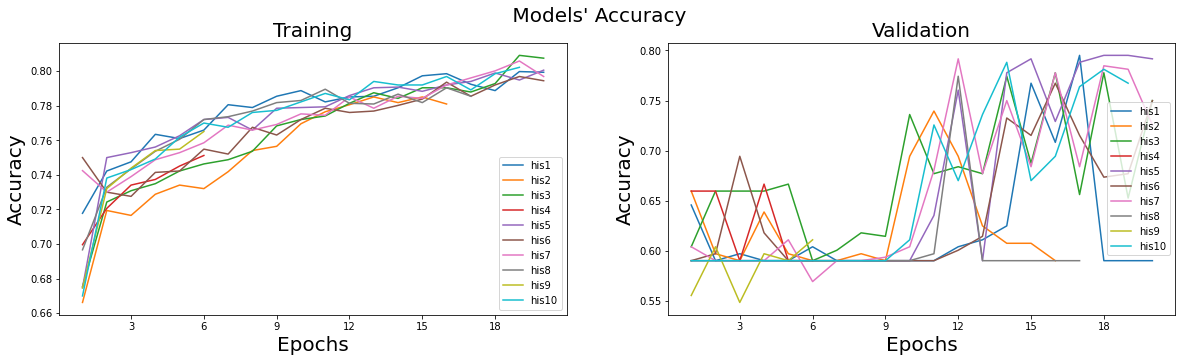

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,5))
fig.suptitle(" Models' Accuracy ", fontsize=20)
ax1.plot(range(1, len(history['0']['accuracy']) + 1), history['0']['accuracy'])
ax1.plot(range(1, len(history['1']['accuracy']) + 1), history['1']['accuracy'])
ax1.plot(range(1, len(history['2']['accuracy']) + 1), history['2']['accuracy'])
ax1.plot(range(1, len(history['3']['accuracy']) + 1), history['3']['accuracy'])
ax1.plot(range(1, len(history['4']['accuracy']) + 1), history['4']['accuracy'])
ax1.plot(range(1, len(history['5']['accuracy']) + 1), history['5']['accuracy'])
ax1.plot(range(1, len(history['6']['accuracy']) + 1), history['6']['accuracy'])
ax1.plot(range(1, len(history['7']['accuracy']) + 1), history['7']['accuracy'])
ax1.plot(range(1, len(history['8']['accuracy']) + 1), history['8']['accuracy'])
ax1.plot(range(1, len(history['9']['accuracy']) + 1), history['9']['accuracy'])

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Training', fontsize=20)
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.legend(['his1', 'his2', 'his3', 'his4', 'his5', 'his6', 'his7', 'his8', 'his9', 'his10'])

ax2.plot(range(1, len(history['0']['val_accuracy']) + 1), history['0']['val_accuracy'])
ax2.plot(range(1, len(history['1']['val_accuracy']) + 1), history['1']['val_accuracy'])
ax2.plot(range(1, len(history['2']['val_accuracy']) + 1), history['2']['val_accuracy'])
ax2.plot(range(1, len(history['3']['val_accuracy']) + 1), history['3']['val_accuracy'])
ax2.plot(range(1, len(history['4']['val_accuracy']) + 1), history['4']['val_accuracy'])
ax2.plot(range(1, len(history['5']['val_accuracy']) + 1), history['5']['val_accuracy'])
ax2.plot(range(1, len(history['6']['val_accuracy']) + 1), history['6']['val_accuracy'])
ax2.plot(range(1, len(history['7']['val_accuracy']) + 1), history['7']['val_accuracy'])
ax2.plot(range(1, len(history['8']['val_accuracy']) + 1), history['8']['val_accuracy'])
ax2.plot(range(1, len(history['9']['val_accuracy']) + 1), history['9']['val_accuracy'])
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title('Validation', fontsize=20)
ax2.set_xlabel('Epochs', fontsize=20)
ax2.set_ylabel('Accuracy', fontsize=20)

ax2.legend(['his1', 'his2', 'his3', 'his4', 'his5', 'his6', 'his7', 'his8', 'his9', 'his10'])
# plt.savefig('Accuracy.png', dpi=300, bbox_inches='tight')